Import relevant Libaries 

In [194]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# Visualizations
import matplotlib.pyplot as plt
from matplotlib import pyplot

# TS
from statsmodels.tsa.seasonal import seasonal_decompose

# Cyclical features
from feature_engine.creation import CyclicalFeatures

# Preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, ShuffleSplit

# Set WD
import glob
import os
from pyrsistent import v
os.getcwd()

'E:\\Nils\\Master_Thesis\\scripts\\Development Scripts'

In [210]:
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import xgboost as xgb

## Load Stations

In [289]:
# This bit to define the data that is to be loaded

# Define the directory path where the CSV files are located
input_path = r'../../data/promice/preprocessed/daily/'

# Define a pattern to match the filenames of the CSV files
pattern = '*.csv'

# Use glob to get a list of all files that match the pattern
filenames = glob.glob(input_path + pattern)

dfs = []
for file in filenames:
    df = pd.read_csv(file, index_col=False)
    dfs.append(df)
df = pd.concat(dfs)

In [290]:
stations = [
'KPC_L',
'SCO_L',
'SCO_U',
'THU_L',
'UPE_L',
'UPE_U',
'MIT',
'TAS_L',
'KAN_L',
'NUK_L',
'NUK_U',
'QAS_L',
'QAS_U',]

df = df[df['stid'].isin(stations)]

## Pre-processing 0.1 (Pre-Modelling Considerations)

In [291]:
## This bit to detect melt onset & melt end day based on the ablation columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")
df['Year'] = df['Datetime'].dt.year
df['DayOfYear'] = df['Datetime'].dt.dayofyear

# Initialize new columns with default values
df['first_melt_day'] = False
df['last_melt_day'] = False

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    unique_years = df_station['Year'].unique()
    for year in unique_years:
        # Filter data for the current year
        year_data = df_station[df_station['Year'] == year]

        # Find the first and last melt day
        first_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].min()
        last_melt_day = year_data.loc[year_data['Ablation'] == True]['DayOfYear'].max()

        # Update the original DataFrame
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == first_melt_day), 'first_melt_day'] = True
        df.loc[(df['stid'] == i) & (df['Year'] == year) & (df['DayOfYear'] == last_melt_day), 'last_melt_day'] = True
base_df = df

## Pre-Processing 0.2 (Target variable Calculation)

In [292]:
# This bit to decompose for each station
df = df[df['Surface height from combined measurements'].notna()] # remove NaN from target

for i in df["stid"].unique().tolist():
    df_station = df[df['stid'] == i]
    if len(df_station) > 730: 
        exec(f"result_{i} = seasonal_decompose(df_station['Surface height from combined measurements'], model='additive', period=365)")
    else:
        print("Station to remove:", i)
        

In [293]:
# This bit to add decomposition to df
ts = pd.DataFrame()

for i in df["stid"].unique().tolist():
    
    # Get data frame for the current station
    df_station = df[df['stid'] == i]

    df_station['observed'] = eval(f"result_{i}.observed")
    df_station['residual'] = eval(f"result_{i}.resid") 
    df_station['seasonal'] = eval(f"result_{i}.seasonal") 
    df_station['trend'] = eval(f"result_{i}.trend")
    df_station['residual_smoothed'] = eval(f"result_{i}.resid") 
    
    # Set the window size and threshold
    window_size = 7
    
    #Outliers based on incremental sum
    threshold_incremental_sum = df_station['residual'].diff().rolling(window_size).sum().quantile(0.8)
    threshold_slope = df_station['residual_smoothed'].diff().abs().quantile(0.8)
        # Calculate the sum of incremental changes over the rolling window
    incremental_sum = df_station['residual'].diff().rolling(window_size).sum()
        # Replace the residuals that exceed the threshold with NaN
    df_station['residual_smoothed'] = df_station['residual']
    df_station.loc[incremental_sum > threshold_incremental_sum, 'residual_smoothed'] = np.nan

    # Outliers based on slope
    slope = df_station['residual_smoothed'].diff().abs()
        # Calculate the 80th percentile of the slopes
    threshold_slope = slope.quantile(0.8)
        # Remove values where the slope is steeper than the threshold
    df_station.loc[slope > threshold_slope, 'residual_smoothed'] = np.nan

    # fill in the NaN values with linear interpolation
    #df_station['residual_smoothed'].interpolate(method='linear', inplace=True)

    # Add new column for seasonal residual
    df_station['seasonal_residual'] = df_station['residual'].fillna(0) + df_station['seasonal']
    
    # Add column for current station
    df_station['stid'] = i
    
    # Append to time series data frame
    ts = ts.append(df_station[['Datetime', 'stid', 'observed', 'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual']])

# Merge time series data frame with original data frame
df = pd.merge(df, ts, on=['Datetime', 'stid'], how='left')


In [294]:
#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 

# Reset the index for cyclical_df
cyclical_df.reset_index(inplace=True)

# Merge the original df with the cyclical_df using a left join
df = pd.merge(df.reset_index(), cyclical_df, left_on='index', right_on='index', how='left')

In [295]:
# Create Lags and averages

# sort values by 'stid', 'Datetime'
df = df.sort_values(by=['stid', 'Datetime'])

# set periods for lags and rolling averages
periods = [40, 60, 90]
periods = [60,70,80,90]

# feature columns
features = [
    'Air pressure (upper boom)', 'Air temperature (upper boom)',
    'Relative humidity (upper boom) - corrected',
    'Specific humidity (upper boom)', 'Wind speed (upper boom)',
    'Wind from direction (upper boom)',
    'Downwelling shortwave radiation - corrected',
    'Upwelling shortwave radiation - corrected',
    'Downwelling longwave radiation', 'Upwelling longwave radiation',
    'Surface temperature', 'Latent heat flux (upper boom)',
    'Sensible heat flux (upper boom)', 'Albedo', 'Cloud cover', 
    'residual', 'seasonal', 'trend', 'residual_smoothed', 'seasonal_residual',
    'Surface height from combined measurements',
    'Surface height from combined measurements DELTA'
]

# for each station id
for stid in df['stid'].unique():
    for feature in features:
        for period in periods:
            df.loc[df['stid'] == stid, f'{feature}_lag_{period}'] = df.loc[df['stid'] == stid, feature].shift(period)
         #   df.loc[df['stid'] == stid, f'{feature}_rolling_avg_{period}'] = df.loc[df['stid'] == stid, feature].rolling(window=period).mean()


In [265]:
## This bit to filter by the +- 10 days around melt onset/ melt end

# Convert your Datetime column to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract year from the Datetime column
df['year'] = df['Datetime'].dt.year

start_day_first = 10
end_day_first = 10
start_day_last = 10
end_day_last = 10

# Define a custom function to filter rows based on the conditions
def filter_melt_days(group):
    first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
    last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

    start_date = first_melt_day - pd.Timedelta(days=start_day_first)
    end_date = last_melt_day + pd.Timedelta(days=end_day_last)

    return group[(group['Datetime'] >= start_date) & (group['Datetime'] <= end_date)]

# Apply the custom function to each group of 'stid' and 'year' and concatenate the results
df = df.groupby(['stid', 'year']).apply(filter_melt_days).reset_index(drop=True)

for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
    
# Define a custom function to extract the expanded indices from the filtered DataFrame
def extract_expanded_indices(filtered_df):
    expanded_indices_first = []
    expanded_indices_last = []

    for (stid, year), group in filtered_df.groupby(['stid', 'year']):
        first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
        last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

        start_date_first = first_melt_day - pd.Timedelta(days=start_day_first)
        end_date_first = first_melt_day + pd.Timedelta(days=end_day_first)

        start_date_last = last_melt_day - pd.Timedelta(days=start_day_last)
        end_date_last = last_melt_day + pd.Timedelta(days=end_day_last)

        expanded_first = group[(group['Datetime'] >= start_date_first) & (group['Datetime'] <= end_date_first)].index
        expanded_last = group[(group['Datetime'] >= start_date_last) & (group['Datetime'] <= end_date_last)].index

        expanded_indices_first.extend(expanded_first)
        expanded_indices_last.extend(expanded_last)

    return expanded_indices_first, expanded_indices_last

# Extract the expanded indices for first and last melt days
expanded_indices_first, expanded_indices_last = extract_expanded_indices(df)


In [296]:
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [297]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season',
                #'month',
                'month_sin',
                'month_cos',
                #'day', 
                'day_sin',
                'day_cos',
                'hour', 
                #'year',
                'year_sin',
                'year_cos'
                'subgroup',
             #   'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
               # 'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                #'DayOfYear',
                'Datetime',
                'day_of_year',
                #'seasonal_residual'
                
               # 'Air pressure (upper boom)', 
               # 'Air temperature (upper boom)',
               # 'Relative humidity (upper boom) - corrected',
               # 'Specific humidity (upper boom)', 
               # 'Wind speed (upper boom)',
               # 'Wind from direction (upper boom)_cos',
               # 'Wind from direction (upper boom)_sin',
               # 'Downwelling shortwave radiation - corrected',
               # 'Upwelling shortwave radiation - corrected',
               # 'Downwelling longwave radiation',
               # 'Upwelling longwave radiation',
               # 'Surface temperature', 
               # 'Latent heat flux (upper boom)',
               # 'Sensible heat flux (upper boom)', 
               # 'Albedo', 
               # 'Cloud cover', 
               # 'residual', 
               # 'seasonal', 
               # 'residual_smoothed', 
               # 'Surface height from combined measurements DELTA'
               ]

df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['day'] = pd.to_numeric(df['day'], errors='coerce')
df['DayOfYear'] = pd.to_numeric(df['DayOfYear'], errors='coerce')

df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [298]:
# This bit to convert all numerical values into the same scale 
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
              'DayOfYear'
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

#df['seasonal_residual'] = scaler.fit_transform(df['seasonal_residual'].values.reshape(-1, 1))
#data['seasonal_residual'] = scaler.fit_transform(data['seasonal_residual'].values.reshape(-1, 1))

In [299]:
# Set the start and end date
start_date = '2019-05-15'
end_date = '2019-06-20'
end_date = '2019-07-05'

df['Datetime'] = pd.to_datetime(df[['year', 'month', 'day']])
data['Datetime'] = pd.to_datetime(data[['year', 'month', 'day']])

# Filter the dataframe to include only rows between the start and end date
SCO_L = df[(df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)  & (df['stid'] == 7)]

#Exclude holdout set from df and data
df = df[~((df['Datetime'] >= start_date) & (df['Datetime'] <= end_date) & (df['stid'] == 7))]
#data = data[~((data['Datetime'] >= start_date) & (data['Datetime'] <= end_date) & (data['stid'] == 7))]

exclude_list =['seasonal_residual', 'Surface height from combined measurements', 'Datetime']
SCO_L_trend = SCO_L[[column for column in SCO_L.columns if column not in exclude_list]]

exclude_list =['trend', 'Surface height from combined measurements', 'Datetime']
SCO_L_seasonal_residual = SCO_L[[column for column in SCO_L.columns if column not in exclude_list]]

In [300]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle = True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8}
------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.9448935908481099
MSE on validation set (seasonal_residual):  0.04688585456063956
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_trend:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8}
------------------------------------------------------------------------------------
R^2 score on validation set (trend):  0.9999869473173726
MSE on validation set (trend):  0.003672884955875912
R^2 score on validation set (combined):  0.9998217852161728
MSE on validation set (combined):  0.05022072012535815


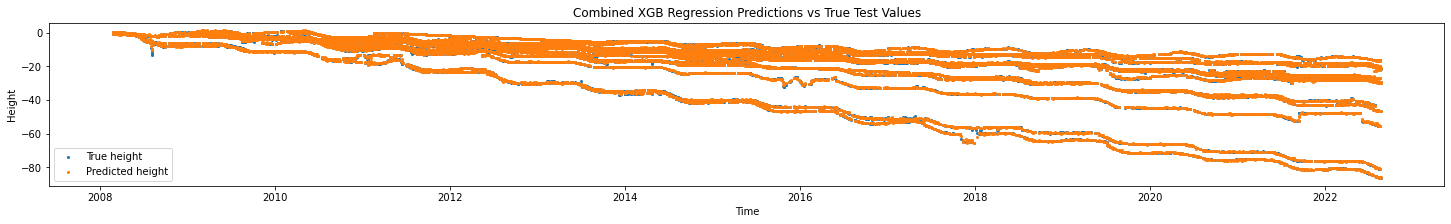

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (combined):  0.9997342742010512
MSE on test set (combined):  0.061264724998935545


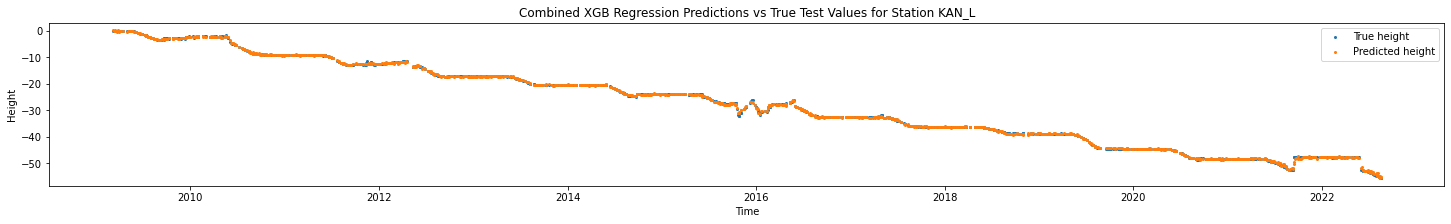

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (combined):  0.9991506876324762
MSE on test set (combined):  0.050110068562921994


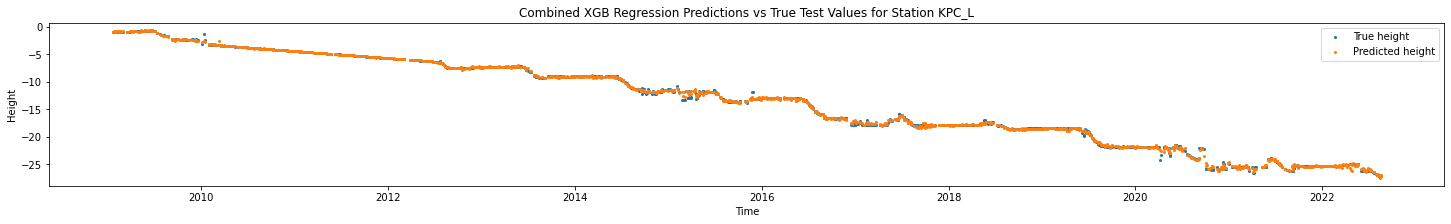

------------------------------------------------------------------------------------
MIT
R^2 score on test set (combined):  0.9976584407197766
MSE on test set (combined):  0.11512492523792474


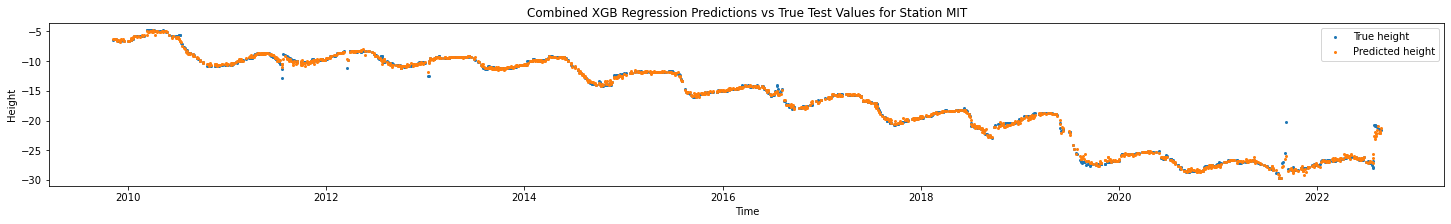

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (combined):  0.9997946590660527
MSE on test set (combined):  0.10501580834830944


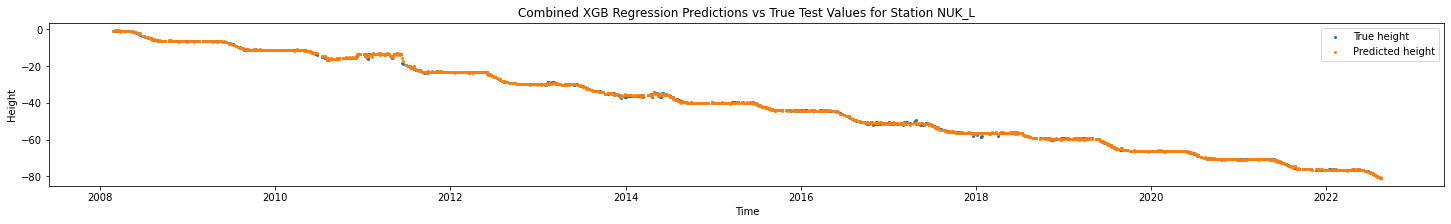

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (combined):  0.999331373978995
MSE on test set (combined):  0.03514314465290151


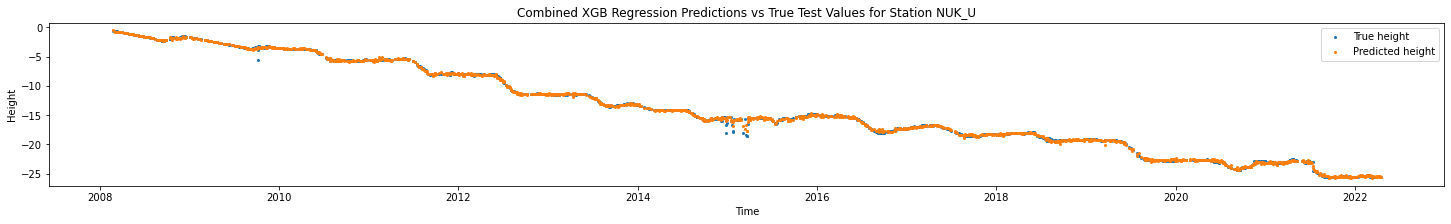

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (combined):  0.999855340219278
MSE on test set (combined):  0.08576082508619015


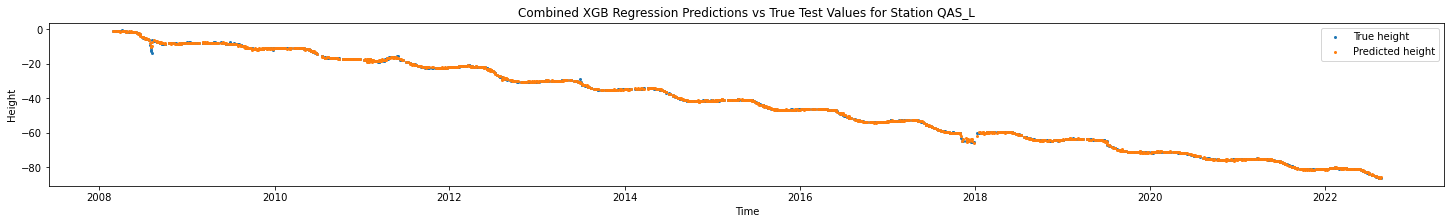

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (combined):  0.9975932797587399
MSE on test set (combined):  0.049864864356974986


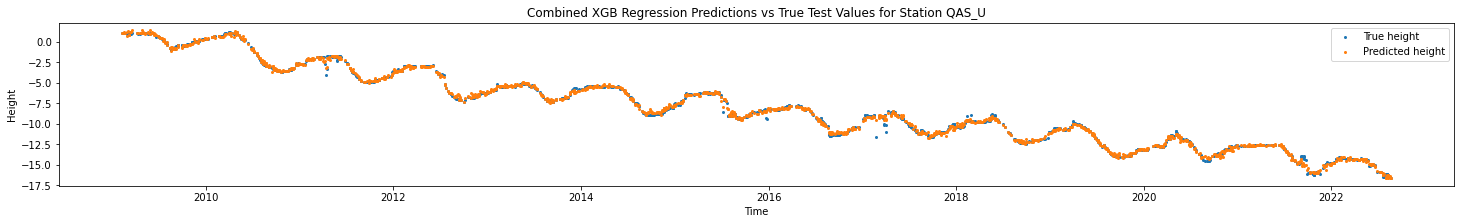

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (combined):  0.9998575294895554
MSE on test set (combined):  0.019019481930354885


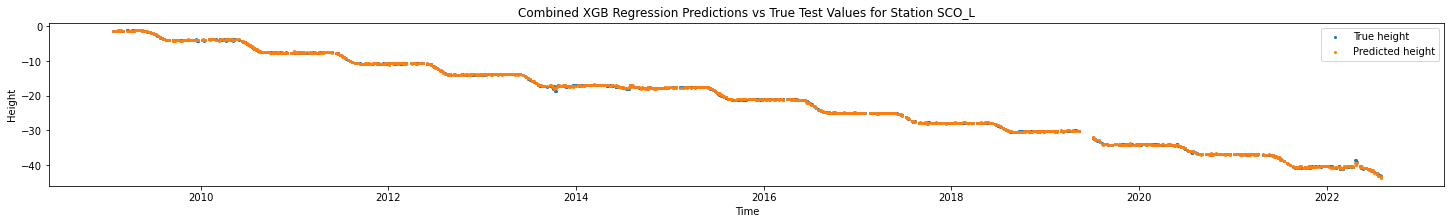

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (combined):  0.9995913856810258
MSE on test set (combined):  0.026012202557877204


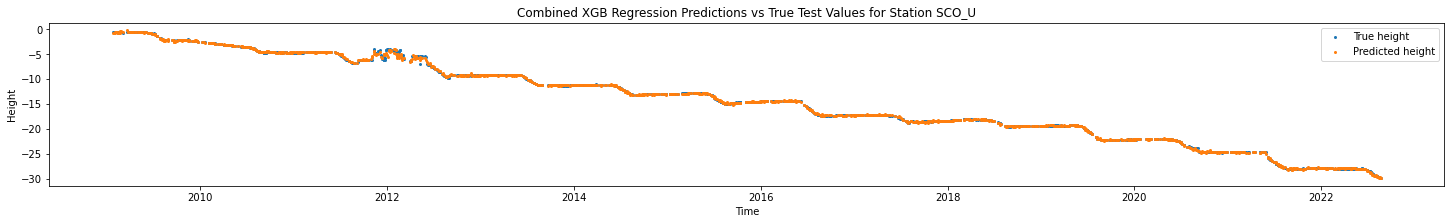

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (combined):  0.999760088864811
MSE on test set (combined):  0.0388981293164087


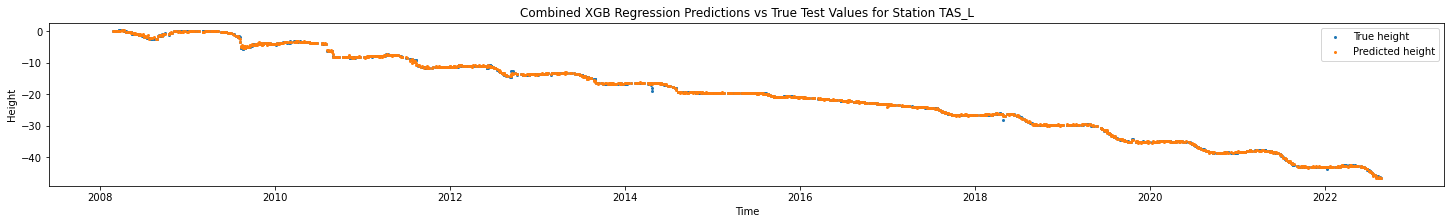

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (combined):  0.9997503434921671
MSE on test set (combined):  0.007479636283905944


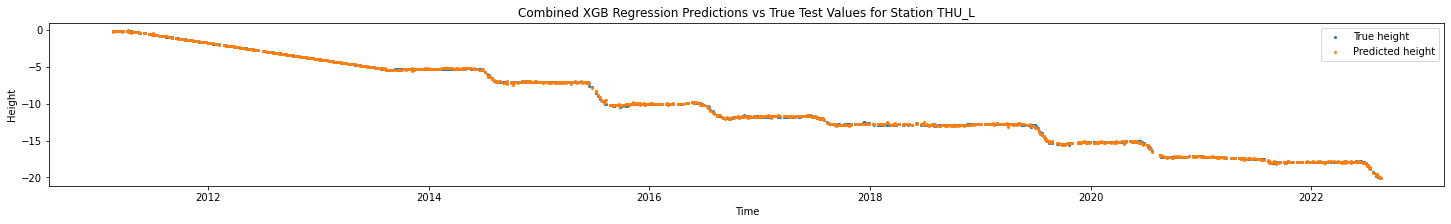

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (combined):  0.9995369042875316
MSE on test set (combined):  0.027631631353824335


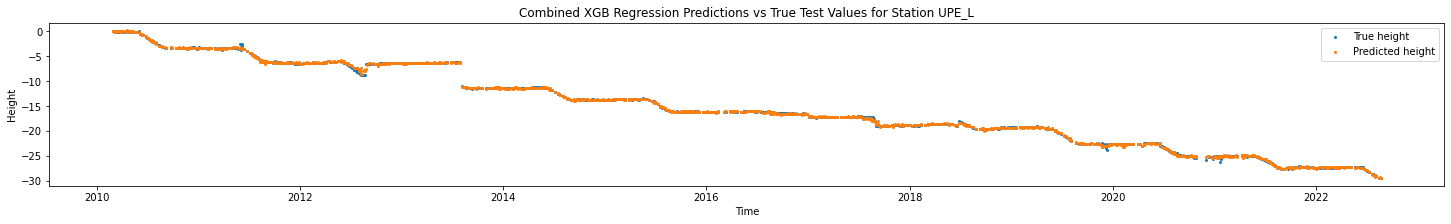

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (combined):  0.9993075344482341
MSE on test set (combined):  0.019565357292356374


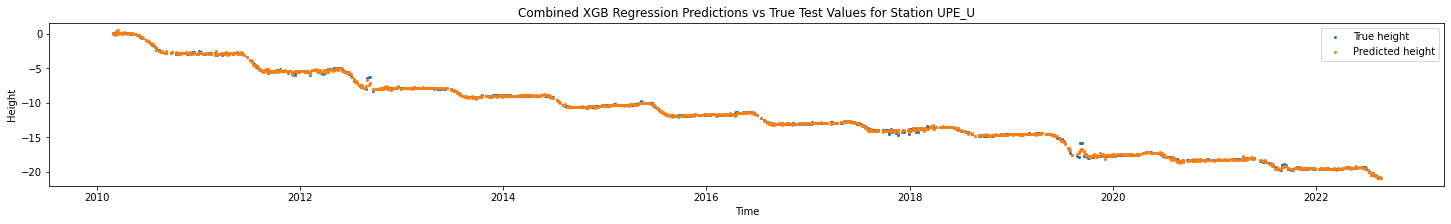

In [301]:
df = df[df['seasonal_residual'].notna() & df['trend'].notna()] # Remove NaN from targets

exclude_list =['Surface height from combined measurements', 'Datetime']
df = df[[column for column in df.columns if column not in exclude_list]]

def train_test(seasonal_residual,trend, df):
        
    # Get unique stid values
    stid_values = df['stid'].unique()

    # Initialize empty lists to store train and test data
    X_train_seasonal_residual, X_test_seasonal_residual, y_train_seasonal_residual, y_test_seasonal_residual = [], [], [], []
    X_train_trend, X_test_trend, y_train_trend, y_test_trend = [], [], [], []

    # Loop through each stid value and split the data into train and test sets
    for stid in stid_values:
        # Get rows corresponding to the current stid value
        subset_df = df[df['stid'] == stid]

        # Define the feature and target variables
        X = subset_df.drop([seasonal_residual, trend], axis=1)
        y = subset_df[[seasonal_residual, trend]]

        # Split the data into training and testing sets
        X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
            X, y, test_size=0.3, random_state=123, shuffle=True)
        
        # Append the train and test data to the lists
        columns_to_keep = [col for col in y_train_subset.columns if col != trend]
        X_train_seasonal_residual.append(X_train_subset)
        X_test_seasonal_residual.append(X_test_subset)
        y_train_seasonal_residual.append(y_train_subset[columns_to_keep])
        y_test_seasonal_residual.append(y_test_subset[columns_to_keep])
        
        columns_to_keep = [col for col in y_train_subset.columns if col != seasonal_residual]
        X_train_trend.append(X_train_subset)
        X_test_trend.append(X_test_subset)
        y_train_trend.append(y_train_subset[columns_to_keep])
        y_test_trend.append(y_test_subset[columns_to_keep])

    # Concatenate the train and test data into a single dataframe
    X_train_seasonal_residual = pd.concat(X_train_seasonal_residual)
    X_test_seasonal_residual = pd.concat(X_test_seasonal_residual)
    y_train_seasonal_residual = pd.concat(y_train_seasonal_residual)
    y_test_seasonal_residual = pd.concat(y_test_seasonal_residual)
    
   # Concatenate the train and test data into a single dataframe
    X_train_trend = pd.concat(X_train_trend)
    X_test_trend = pd.concat(X_test_trend)
    y_train_trend = pd.concat(y_train_trend)
    y_test_trend = pd.concat(y_test_trend)
    
    return X_train_seasonal_residual, X_test_seasonal_residual, y_train_seasonal_residual, y_test_seasonal_residual,X_train_trend, X_test_trend,y_train_trend,y_test_trend 

X_train_seasonal_residual, X_test_seasonal_residual, y_train_seasonal_residual, y_test_seasonal_residual,X_train_trend, X_test_trend,y_train_trend,y_test_trend = train_test('seasonal_residual', 'trend',df)

# Train function
def train_xgb_model(X_train, X_test, y_train, y_test, target):       

    ## Define the model (and grid)
    model = xgb.XGBRegressor()
    param_grid = {
        'colsample_bytree': [1], 'gamma': [0], 'learning_rate': [0.2], 
        'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
    }
    
    #param_grid ={
    #'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    #'max_depth': [5, 13, 15],
    #'min_child_weight': [1, 4, 10], 
    #'gamma': [0, 0.5,  1], 
    #'subsample': [0.5, 0.8, 1], 
    #'colsample_bytree': [0.5, 0.8, 1]
    #}
    
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
    
    grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)
    grid_search.fit(X_train, y_train)

    print(f"Best hyperparameters_{target}: ", grid_search.best_params_)
    print('------------------------------------------------------------------------------------')
    exec(f"xgb_model_{target} = grid_search.best_estimator_")

    y_pred = eval(f"xgb_model_{target}").predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred, squared=True)

    print(f"R^2 score on validation set ({target}): ", r2)
    print(f"MSE on validation set ({target}): ", mse)

    return eval(f"xgb_model_{target}")

# Training the models
xgb_model_seasonal_residual = train_xgb_model(X_train_seasonal_residual, X_test_seasonal_residual, y_train_seasonal_residual, y_test_seasonal_residual, 'seasonal_residual')
xgb_model_trend = train_xgb_model(X_train_trend, X_test_trend,y_train_trend,y_test_trend, 'trend')

# Combine predictions
df_combined = df[df.index.isin(X_test_trend.index)]

exclude_list =['seasonal_residual']
df_trend = df_combined[[column for column in df_combined.columns if column not in exclude_list]]

exclude_list =['trend']
df_seasonal_residual = df_combined[[column for column in df_combined.columns if column not in exclude_list]]

df_combined['predicted_trend'] = xgb_model_trend.predict(df_trend.drop('trend', axis=1))
df_combined['predicted_seasonal_residual'] = xgb_model_seasonal_residual.predict(df_seasonal_residual.drop('seasonal_residual', axis=1))
df_combined['predicted_height'] = df_combined['predicted_trend'] + df_combined['predicted_seasonal_residual']

# Calculate the performance
df_true = data[data['seasonal_residual'].notna() & data['trend'].notna()]
df_true = df_true[df_true.index.isin(X_test_trend.index)]

true_height = df_true['Surface height from combined measurements']
predicted_height = df_combined['predicted_height']
r2_combined = r2_score(true_height, predicted_height)
mse_combined = mean_squared_error(true_height, predicted_height, squared=True)

print(f"R^2 score on validation set (combined): ", r2_combined)
print(f"MSE on validation set (combined): ", mse_combined)

df_combined['Datetime'] = pd.to_datetime(df_combined[['year', 'month', 'day']])
# Plotting the combined predicted values against true values
plt.figure(figsize=(25, 3))
plt.scatter(df_combined.Datetime, true_height, label="True height", alpha=1, s=4)
plt.scatter(df_combined.Datetime, predicted_height, label="Predicted height", alpha=1, s=4)
plt.xlabel("Time")
plt.ylabel("Height")
plt.title("Combined XGB Regression Predictions vs True Test Values")
plt.legend()
plt.show()

# Station wise performance
for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset df_combined with the values of station_names
    df_combined_station = df_combined.loc[df_combined['stid'] == value]
    
    if len(df_combined_station) == 0:
        continue
    else:
        # Subset true_height and predicted_height with the indices of df_combined_station
        true_height_station = true_height.loc[df_combined_station.index]
        predicted_height_station = predicted_height.loc[df_combined_station.index]

        r2_station = r2_score(true_height_station, predicted_height_station)
        mse_station = mean_squared_error(true_height_station, predicted_height_station, squared=True)

        print(f"R^2 score on test set (combined): ", r2_station)
        print(f"MSE on test set (combined): ", mse_station)

        plt.figure(figsize=(25, 3))
        plt.scatter(df_combined_station.Datetime, true_height_station, label="True height", alpha=1, s=4)
        plt.scatter(df_combined_station.Datetime, predicted_height_station, label="Predicted height", alpha=1, s=4)

        plt.xlabel("Time")
        plt.ylabel("Height")
        plt.title("Combined XGB Regression Predictions vs True Test Values for Station "+station_name)
        plt.legend()
        plt.show()


R^2 score on validation set (combined):  -0.20167304350455595
MSE on validation set (combined):  2.097920992698973


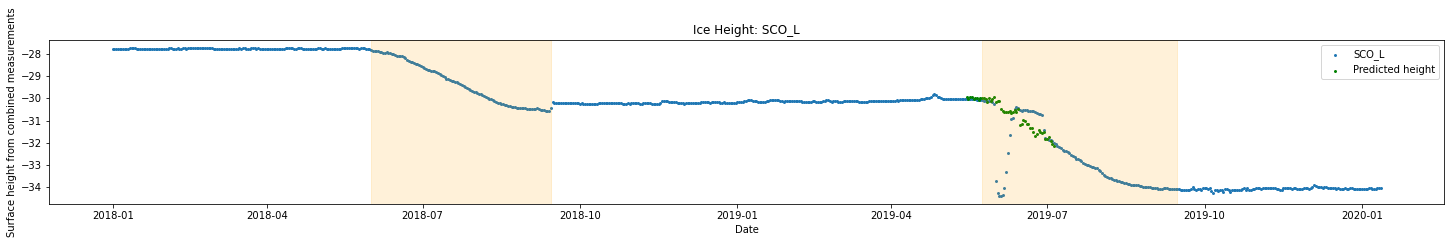

In [310]:
SCO_L['predicted_trend'] = xgb_model_trend.predict(SCO_L_trend.drop('trend', axis=1))
SCO_L['predicted_seasonal_residual'] = xgb_model_seasonal_residual.predict(SCO_L_seasonal_residual.drop('seasonal_residual', axis=1))
SCO_L['predicted_height'] = SCO_L['predicted_trend'] + SCO_L['predicted_seasonal_residual']

df_true = data[data.index.isin(SCO_L.index)]

true_height = df_true['Surface height from combined measurements']
predicted_height = SCO_L['predicted_height']
r2_combined = r2_score(true_height, predicted_height)
mse_combined = mean_squared_error(true_height, predicted_height, squared=True)

print(f"R^2 score on validation set (combined): ", r2_combined)
print(f"MSE on validation set (combined): ", mse_combined)

SCO_L['Datetime'] = pd.to_datetime(SCO_L[['year', 'month', 'day']])

# Set the start and end date
start_date = '2018-01-01'
end_date = '2020-01-12'

base_df['Datetime'] = pd.to_datetime(base_df['Datetime'])
# Filter the dataframe to include only rows between the start and end date
station_df = base_df[(base_df['Datetime'] >= start_date) & (base_df['Datetime'] <= end_date) & (base_df['stid'] == 'SCO_L')]

# filter the dataframe to only include rows where ablation occurred
ablation_df = station_df[station_df['Ablation'] == True]

# create a line plot for each station, highlighting the periods of ablation
fig, ax = plt.subplots(figsize=(25,3))

# Plot the blue scatter points
plt.scatter(station_df['Datetime'], station_df['Surface height from combined measurements'], c='C0',  marker='.', label='SCO_L', s=15)

first_melt_days = station_df[station_df['first_melt_day'] == True]['Datetime']
last_melt_days = station_df[station_df['last_melt_day'] == True]['Datetime']

for first_day, last_day in zip(first_melt_days, last_melt_days):
    ax.axvspan(first_day, last_day, alpha=0.15, color='orange')

# Plot the first melt day values
#plt.scatter(first_melt_days, station_df.loc[first_melt_days.index, 'Surface height from combined measurements'], c='g', alpha=0.8, marker='.', label='First Melt Day', s=100)

# Plot the last melt day values
#plt.scatter(last_melt_days, station_df.loc[last_melt_days.index, 'Surface height from combined measurements'], c='r', alpha=0.8 , marker='.', label='Last Melt Day', s=100)

plt.scatter(SCO_L.Datetime, predicted_height, label="Predicted height",  marker='.', c= 'green', s=15)

# set plot title, axis labels and legend
ax.set_title(f'Ice Height: SCO_L')
ax.set_xlabel('Date')
ax.set_ylabel('Surface height from combined measurements')
ax.legend()


## Pre-Processing 1.0

##### Set target variable

In [15]:
y = 'seasonal_residual'

##### Change wind from direction to cycle

In [16]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df["Datetime"] = pd.to_datetime(df["Datetime"], format="%Y-%m-%d")

#Create new columns
df['year'] = df['Datetime'].dt.year 
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day

In [17]:
# Use CyclicalFeatures Package to convert year, month, day & hour

cyclical = CyclicalFeatures(variables=None, drop_original=True)

# Remove only values from Wind direction because CyclicalFeatures does not work with NA values
df_wind = df[df['Wind from direction (upper boom)'].notna()] 
cyclical_df = cyclical.fit_transform(df_wind[['Wind from direction (upper boom)']]) 

# Reset the index for cyclical_df
cyclical_df.reset_index(inplace=True)

# Merge the original df with the cyclical_df using a left join
df = pd.merge(df.reset_index(), cyclical_df, left_on='index', right_on='index', how='left')

##### Filter relevant periods

In [18]:
df = df[df[y].notna()] # Remove NaN from target

In [19]:
## This bit to filter by the +- 10 days around melt onset/ melt end

# Convert your Datetime column to datetime
df['Datetime'] = pd.to_datetime(df['Datetime'])

# Extract year from the Datetime column
df['year'] = df['Datetime'].dt.year

start_day_first = 10
end_day_first = 10
start_day_last = 10
end_day_last = 10

# Define a custom function to filter rows based on the conditions
def filter_melt_days(group):
    first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
    last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

    start_date = first_melt_day - pd.Timedelta(days=start_day_first)
    end_date = last_melt_day + pd.Timedelta(days=end_day_last)

    return group[(group['Datetime'] >= start_date) & (group['Datetime'] <= end_date)]

# Apply the custom function to each group of 'stid' and 'year' and concatenate the results
df = df.groupby(['stid', 'year']).apply(filter_melt_days).reset_index(drop=True)

for category in [True]:
    exec(f"indices_first_melt_day= df[df['first_melt_day'] == {category}].index")
for category in [True]:
    exec(f"indices_last_melt_day= df[df['last_melt_day'] == {category}].index")
    
# Define a custom function to extract the expanded indices from the filtered DataFrame
def extract_expanded_indices(filtered_df):
    expanded_indices_first = []
    expanded_indices_last = []

    for (stid, year), group in filtered_df.groupby(['stid', 'year']):
        first_melt_day = group[group['first_melt_day'] == True]['Datetime'].min()
        last_melt_day = group[group['last_melt_day'] == True]['Datetime'].max()

        start_date_first = first_melt_day - pd.Timedelta(days=start_day_first)
        end_date_first = first_melt_day + pd.Timedelta(days=end_day_first)

        start_date_last = last_melt_day - pd.Timedelta(days=start_day_last)
        end_date_last = last_melt_day + pd.Timedelta(days=end_day_last)

        expanded_first = group[(group['Datetime'] >= start_date_first) & (group['Datetime'] <= end_date_first)].index
        expanded_last = group[(group['Datetime'] >= start_date_last) & (group['Datetime'] <= end_date_last)].index

        expanded_indices_first.extend(expanded_first)
        expanded_indices_last.extend(expanded_last)

    return expanded_indices_first, expanded_indices_last

# Extract the expanded indices for first and last melt days
expanded_indices_first, expanded_indices_last = extract_expanded_indices(df)


##### Formatting and transformation

In [22]:
## This bit to label encode stations
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
df['stid'] = le.fit_transform(df['stid'])
station_names = dict(zip(le.classes_, le.transform(le.classes_)))

In [23]:
# This bit to include only relevant features
exclude_list = ['index', # excluded because of unimportant information
                #'stid', 
                'Unnamed: 0', # Old Index
                'ID',
                'Wind from direction (upper boom)',
                'Ablation',
                'Melting Season', # We drop melting season later 
                #'month',
                'month_sin',
                'month_cos',
                #'day', 
                'day_sin',
                'day_cos',
                'hour', 
                #'year',
                'year_sin',
                'year_cos'
                'subgroup',
                'Surface height from combined measurements',
                'Surface height from combined measurements DELTA',
                'observed', 
                'residual', 
                'seasonal', 
                'trend',
                'residual_smoothed',
                'Periods',
                'Year',
                'first_melt_day',
                'last_melt_day',
                #'DayOfYear',
                'Datetime',
                'day_of_year',
                #'seasonal_residual'
               ]

df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['month'] = pd.to_numeric(df['month'], errors='coerce')
df['day'] = pd.to_numeric(df['day'], errors='coerce')
df['DayOfYear'] = pd.to_numeric(df['DayOfYear'], errors='coerce')

df = df[[column for column in df.columns if column not in exclude_list]]
data = df.copy()

In [24]:
# This bit to convert all numerical values into the same scale 
scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]

# Exclude whater is not needed for scaling
exlude_num = ['stid', 
              'Surface height from combined measurements', 
              'Surface height from combined measurements DELTA',
              'month_sin',
              'month_cos',
              'month',
              'day', 
              'day_sin',
              'day_cos',
              'hour', 
              'year',
              'year_sin',
              'year_cos'
              'subgroup',
              'Surface height from combined measurements',
              'Surface height from combined measurements DELTA',
              'observed', 
              'residual', 
              'seasonal', 
              'trend',
              'Wind from direction (upper boom)',
              'Wind from direction (upper boom)_sin',
              'Wind from direction (upper boom)_cos',
              'seasonal_residual',
              'residual_smoothed',
              'Datetime',
              'DayOfYear'
             ]


num_cols = df.select_dtypes(include=['int64','float64'])
num_cols = num_cols[[column for column in num_cols.columns if column not in exlude_num]].columns

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])
data[num_cols] = scaler.fit_transform(data[num_cols])

df['seasonal_residual'] = scaler.fit_transform(df['seasonal_residual'].values.reshape(-1, 1))
data['seasonal_residual'] = scaler.fit_transform(data['seasonal_residual'].values.reshape(-1, 1))

In [26]:
# This bit for classical train test split

# Get unique stid values
stid_values = df['stid'].unique()

# Initialize empty lists to store train and test data
X_train, X_test, y_train, y_test = [], [], [], []

# Loop through each stid value and split the data into train and test sets
for stid in stid_values:
    # Get rows corresponding to the current stid value
    subset_df = df[df['stid'] == stid]
    
    # Split the subset into train and test sets
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
        subset_df.drop([y], axis=1), subset_df[y], test_size=0.3, random_state=123, shuffle =True)
    
    # Append the train and test data to the lists
    X_train.append(X_train_subset)
    X_test.append(X_test_subset)
    y_train.append(y_train_subset)
    y_test.append(y_test_subset)

# Concatenate the train and test data into a single dataframe
X_train = pd.concat(X_train)
X_test = pd.concat(X_test)
y_train = pd.concat(y_train)
y_test = pd.concat(y_test)

In [35]:
# This bit to train test split on 2022

train_df = df[df['year'] != 2022]
test_df = df[df['year'] == 2022]

X_train = train_df.drop(y, axis=1)
y_train = train_df[y]

X_test = test_df.drop(y, axis=1)
y_test = test_df[y]

#X_train = pd.concat(X_train)
#X_test = pd.concat(X_test)
#y_train = pd.concat(y_train)
#y_test = pd.concat(y_test)

In [36]:
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=42)

In [55]:
def plot_cv_indices(cv, X, y, ax, n_splits, lw=10):
    for ii, (tr, tt) in enumerate(cv.split(X, y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + 0.5] * len(indices), c=indices, marker="_", lw=lw, cmap=plt.cm.coolwarm, vmin=-0.2, vmax=1.2)

    ax.set_xlabel("Sample index")
    ax.set_ylabel("CV iteration")
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels(list(range(n_splits)))
    ax.set_title("{}".format(type(cv).__name__))
    return ax

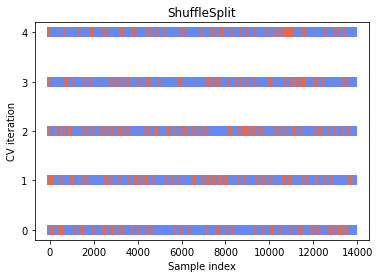

In [56]:
fig, ax = plt.subplots()
plot_cv_indices(cv, X_train, y_train, ax, cv.get_n_splits(X_train, y_train))
plt.show()

## Regression Modelling

In [29]:
from sklearn.metrics import mean_squared_error
from sklearn.experimental import enable_hist_gradient_boosting  # Required to enable HistGradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
import xgboost as xgb

In [30]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=cv, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("R^2")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, shuffle = True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [31]:
def plot_validation_curve(estimator, title, X, y, param_name, param_range, cv=None, n_jobs=-1, log_scale=False):
    train_scores, test_scores = validation_curve(estimator, X, y, param_name=param_name, param_range=param_range, cv=cv, n_jobs=n_jobs)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(title)
    plt.xlabel(f"{param_name}")
    plt.ylabel("Score")
    plt.grid()

    if log_scale:
        plt.xscale("log")

    plt.fill_between(param_range, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(param_range, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(param_range, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(param_range, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 10, 'subsample': 0.8}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.9292487619834423
Standard deviation of R^2 test scores from cv: 0.005199956203846507


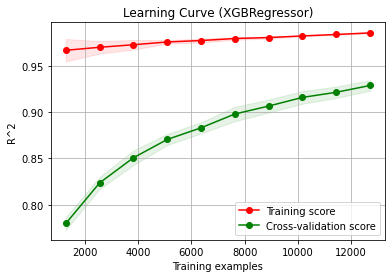

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.49089223555464334
MSE on validation set (seasonal_residual):  0.0028633566170943605


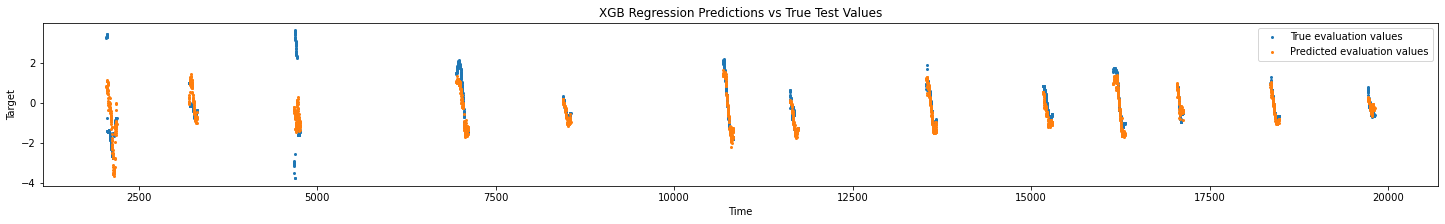

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  -0.025325640470286404
MSE on test set (seasonal_residual):  2.250086696575378


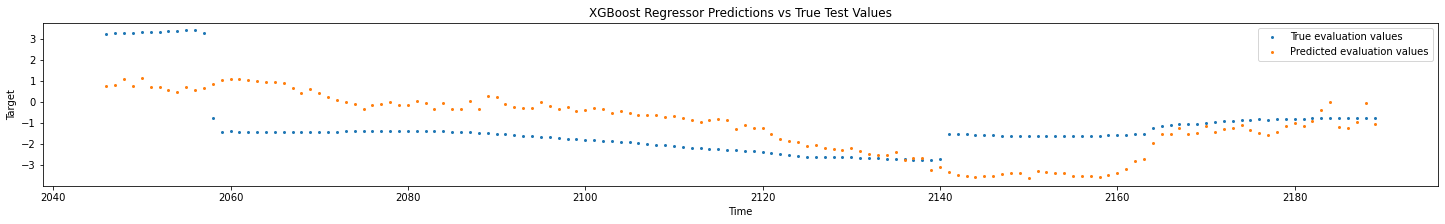

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  -1.6969414837612895
MSE on test set (seasonal_residual):  0.5801707105638222


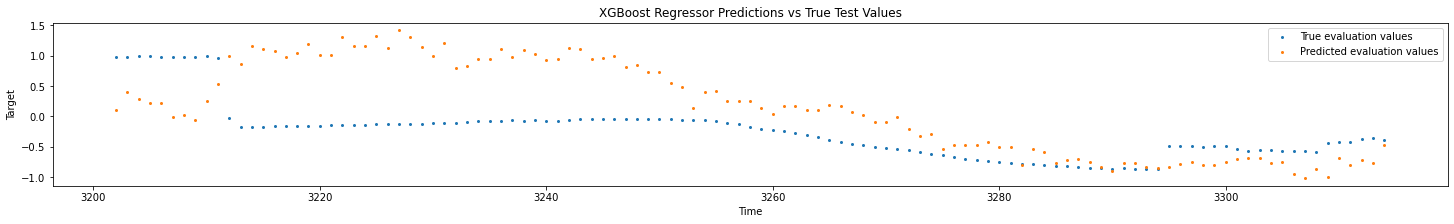

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  -0.21538391668148305
MSE on test set (seasonal_residual):  6.237054947383532


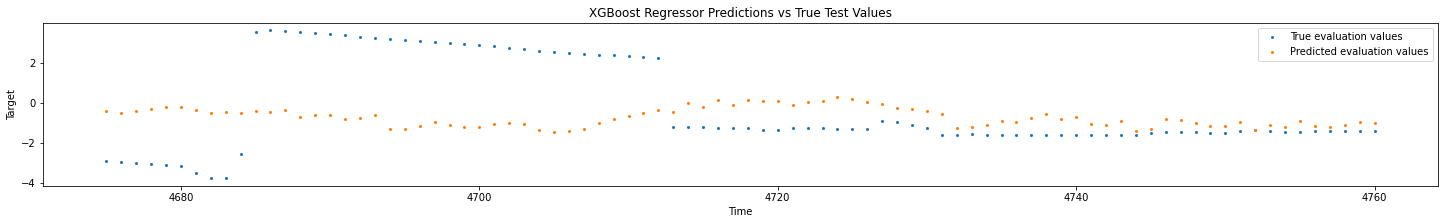

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.7844973992192872
MSE on test set (seasonal_residual):  0.43597602616948433


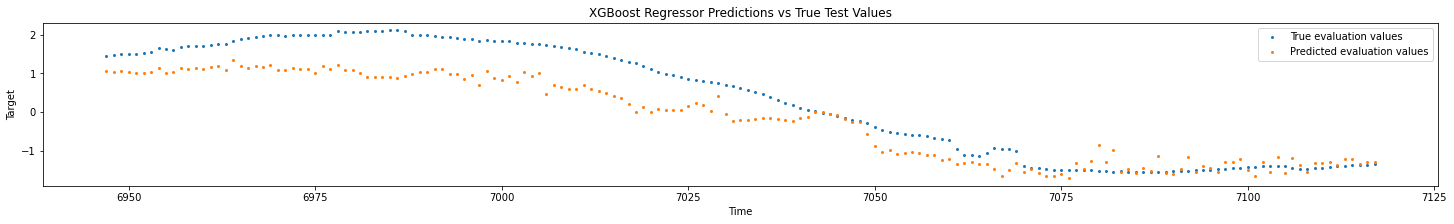

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.5387975689378095
MSE on test set (seasonal_residual):  0.05156248623322717


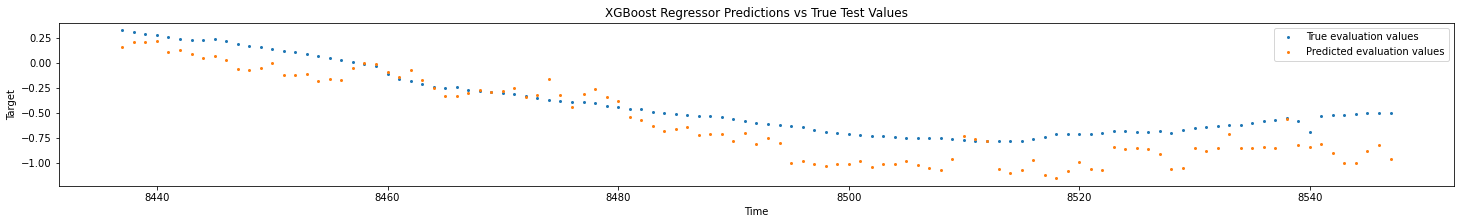

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.9521131132415263
MSE on test set (seasonal_residual):  0.09387202767798472


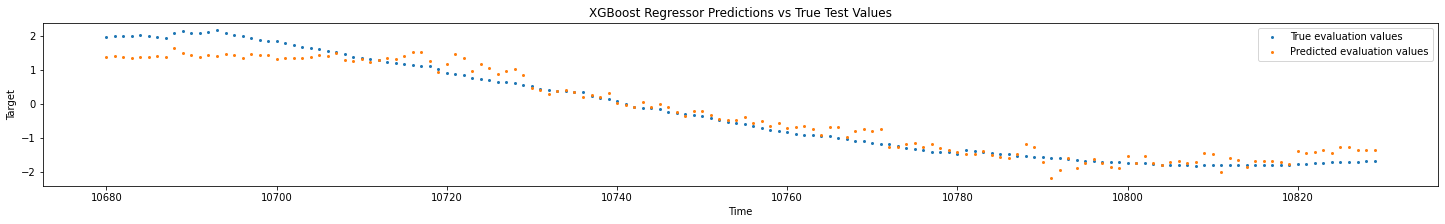

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.6781244955443375
MSE on test set (seasonal_residual):  0.12096461402493948


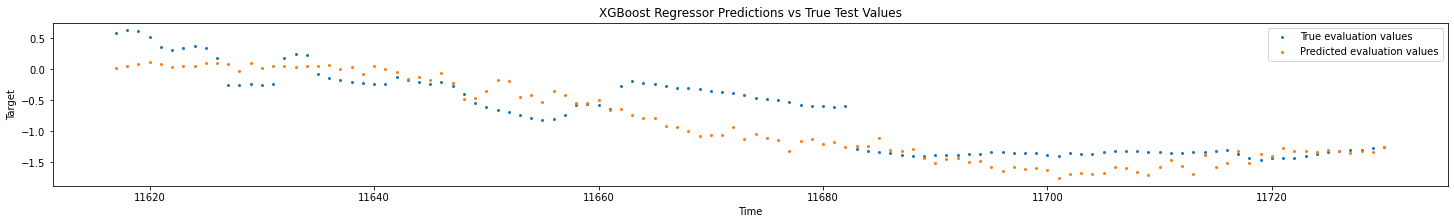

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.8794528980465011
MSE on test set (seasonal_residual):  0.09134168637603983


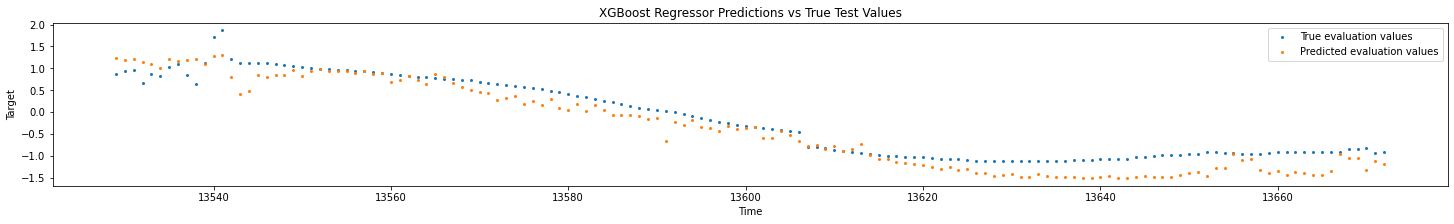

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.3322079822551125
MSE on test set (seasonal_residual):  0.24144561138097936


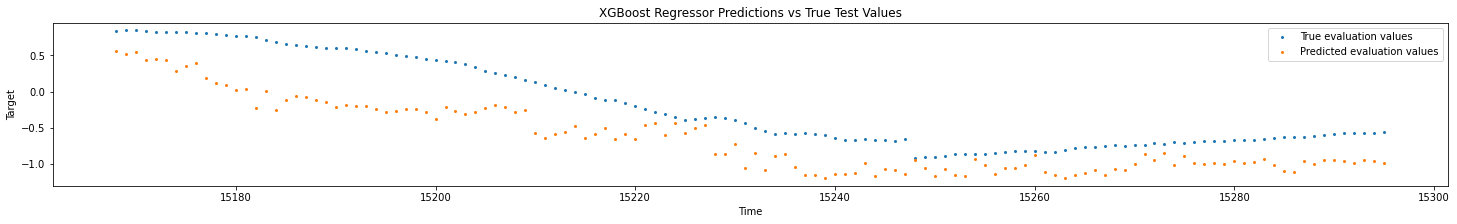

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.8808285277587106
MSE on test set (seasonal_residual):  0.15876012329292408


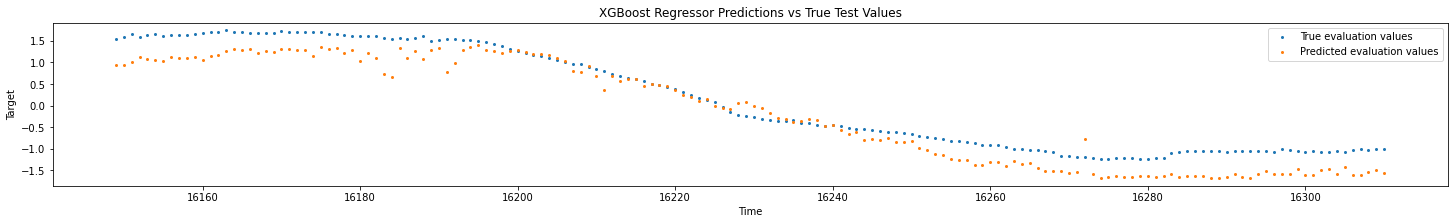

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.7726109885167431
MSE on test set (seasonal_residual):  0.0843043410149222


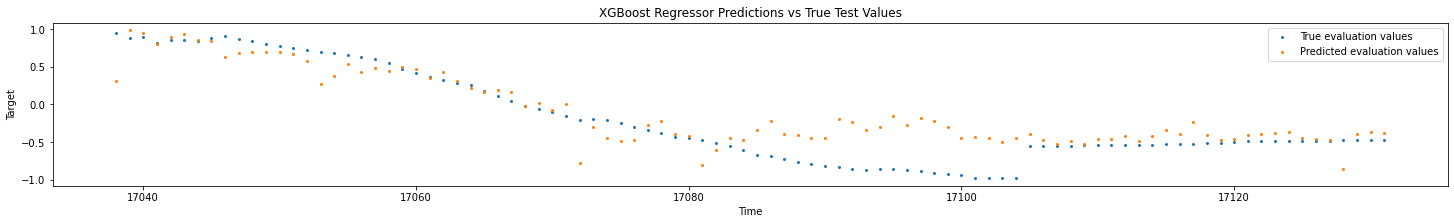

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.907317523536537
MSE on test set (seasonal_residual):  0.03821490082009748


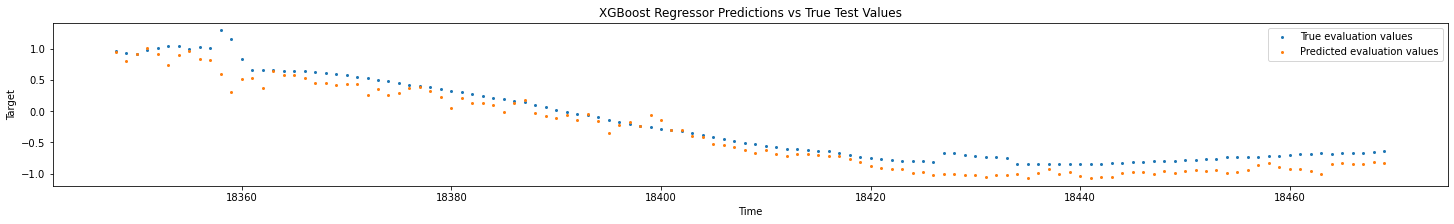

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.5760745320728752
MSE on test set (seasonal_residual):  0.06789547198062176


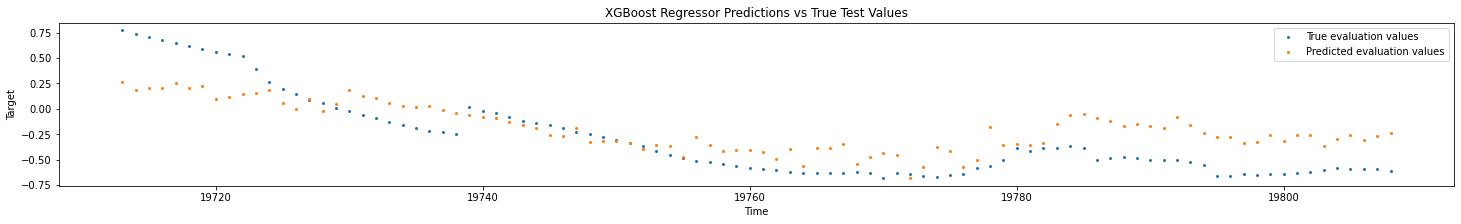

In [37]:
# XGB Regressor
model = xgb.XGBRegressor()

# Grid used in Hyperparameter Tuning
param_grid ={
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 7, 9, 11, 13, 15],
    'min_child_weight': [1, 2, 4, 6, 8, 10], 
    'gamma': [0, 0.1, 0.5, 0.7, 1], 
    'subsample': [0.5, 0.7, 0.8, 0.9, 1], 
    'colsample_bytree': [0.5, 0.7, 0.8, 0.9, 1]
}

param_grid = {
'colsample_bytree': [1], 'gamma': [0], 'learning_rate': [0.05], 'max_depth': [15], 'min_child_weight': [10], 'subsample': [0.8]
}


# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"xgb_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"xgb_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

plot_learning_curve(best_estimator, "Learning Curve (XGBRegressor)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("XGB Regression Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"xgb_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"xgb_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("XGBoost Regressor Predictions vs True Test Values")
    plt.legend()
    plt.show()


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best hyperparameters_seasonal_residual:  {'l2_regularization': 0, 'learning_rate': 0.05, 'max_depth': 15, 'max_iter': 500, 'min_samples_leaf': 10}
------------------------------------------------------------------------------------
Average R^2 test score from cv : 0.9035864749635134
Standard deviation of R^2 test scores from cv: 0.00617199845545549


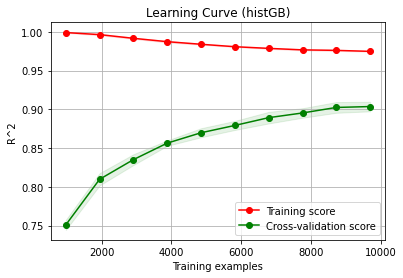

------------------------------------------------------------------------------------
R^2 score on validation set (seasonal_residual):  0.9151087727931565
MSE on validation set (seasonal_residual):  0.0004496665650743795


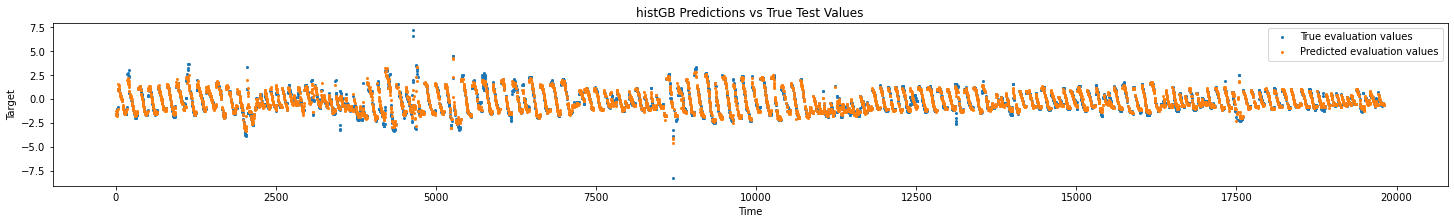

------------------------------------------------------------------------------------
KAN_L
R^2 score on test set (seasonal_residual):  0.9223071303630429
MSE on test set (seasonal_residual):  0.12902725820561006


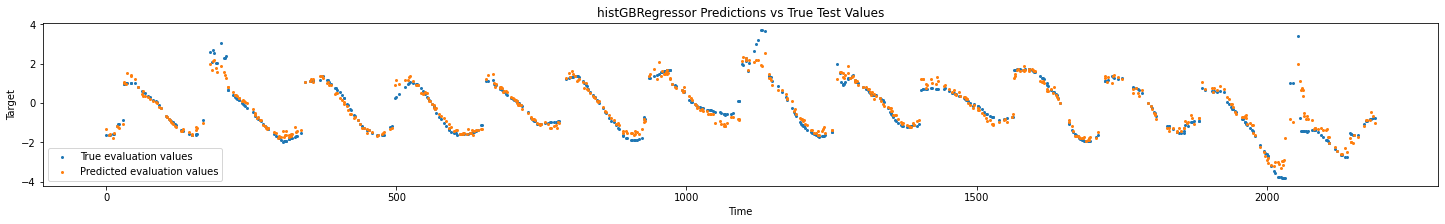

------------------------------------------------------------------------------------
KPC_L
R^2 score on test set (seasonal_residual):  0.8500894262663401
MSE on test set (seasonal_residual):  0.07719579060224692


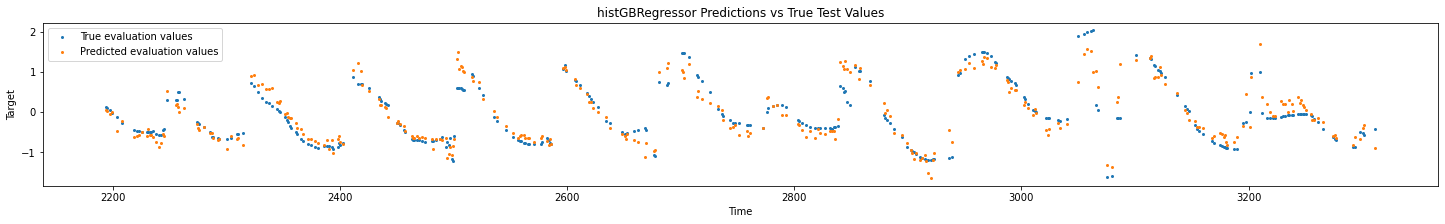

------------------------------------------------------------------------------------
MIT
R^2 score on test set (seasonal_residual):  0.7671482886602169
MSE on test set (seasonal_residual):  0.5142512999950973


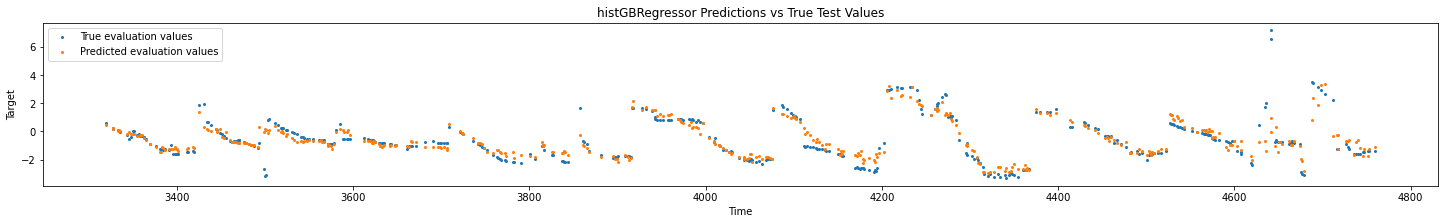

------------------------------------------------------------------------------------
NUK_L
R^2 score on test set (seasonal_residual):  0.959705188830225
MSE on test set (seasonal_residual):  0.08571973268951649


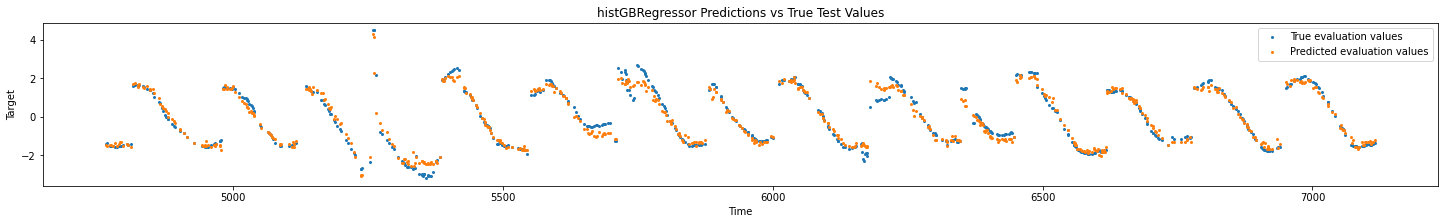

------------------------------------------------------------------------------------
NUK_U
R^2 score on test set (seasonal_residual):  0.912991177412444
MSE on test set (seasonal_residual):  0.03572038639569509


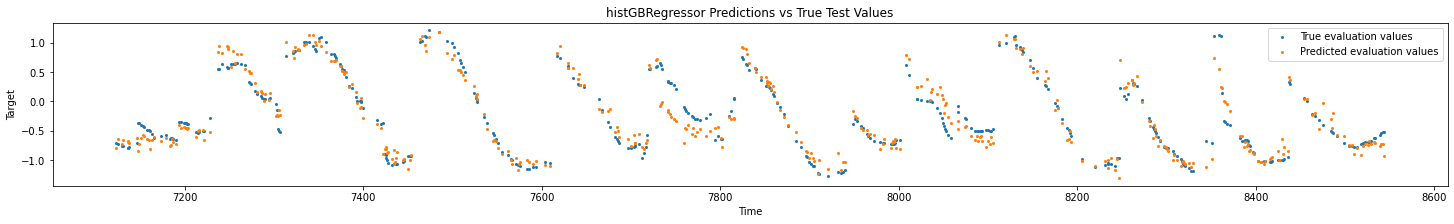

------------------------------------------------------------------------------------
QAS_L
R^2 score on test set (seasonal_residual):  0.9616977539233239
MSE on test set (seasonal_residual):  0.09548727409359507


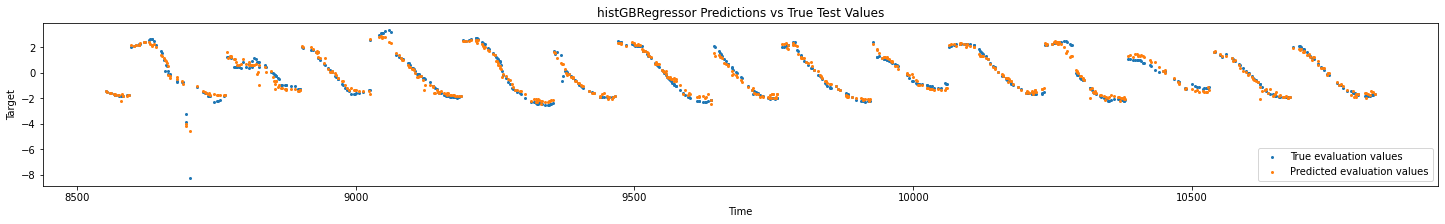

------------------------------------------------------------------------------------
QAS_U
R^2 score on test set (seasonal_residual):  0.8277426961888166
MSE on test set (seasonal_residual):  0.054887999653021276


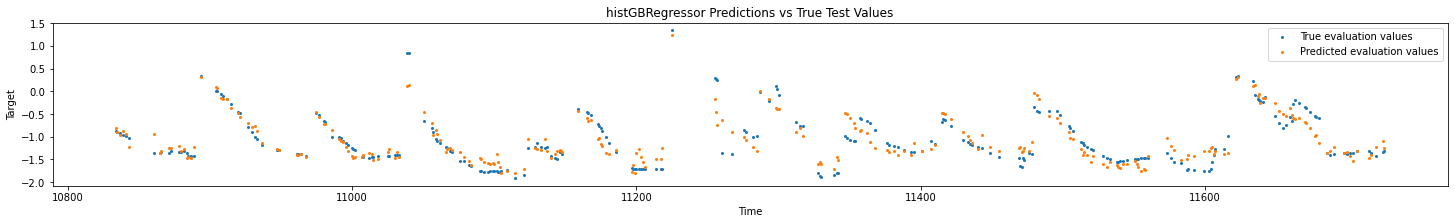

------------------------------------------------------------------------------------
SCO_L
R^2 score on test set (seasonal_residual):  0.8470533590327491
MSE on test set (seasonal_residual):  0.13026816998532237


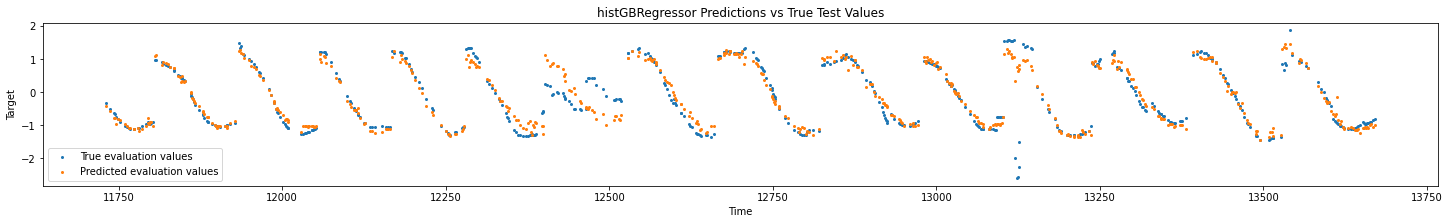

------------------------------------------------------------------------------------
SCO_U
R^2 score on test set (seasonal_residual):  0.9284139851443283
MSE on test set (seasonal_residual):  0.03550275202409998


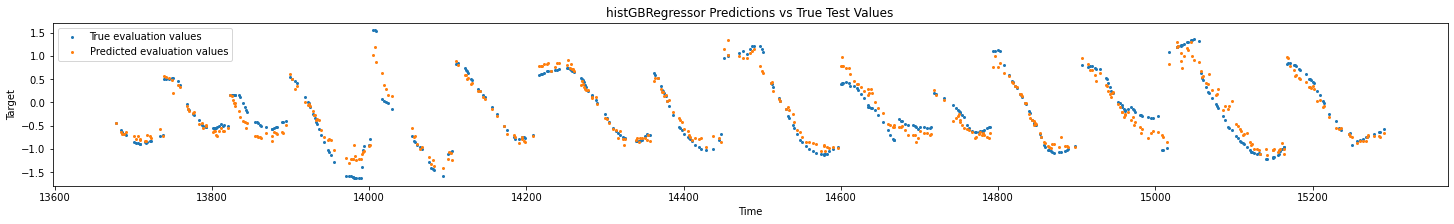

------------------------------------------------------------------------------------
TAS_L
R^2 score on test set (seasonal_residual):  0.9540683618102799
MSE on test set (seasonal_residual):  0.04866192467512013


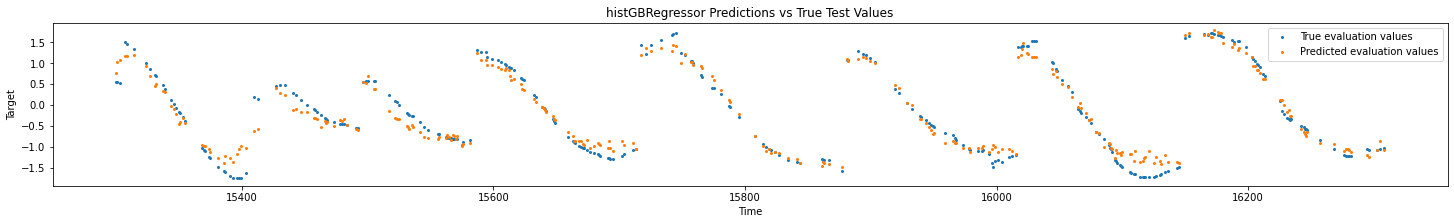

------------------------------------------------------------------------------------
THU_L
R^2 score on test set (seasonal_residual):  0.858371016496327
MSE on test set (seasonal_residual):  0.04972090130179212


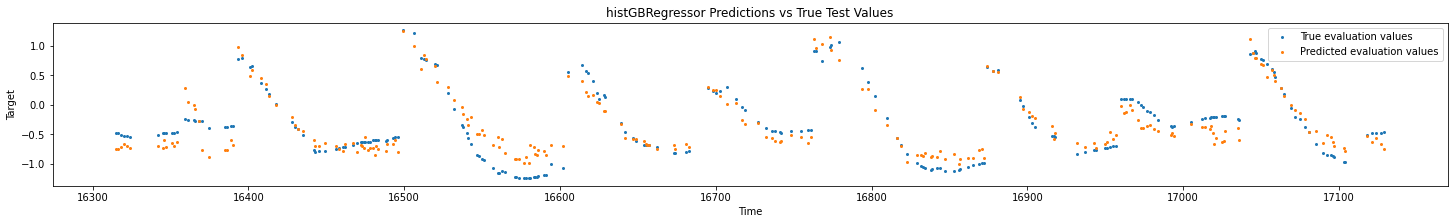

------------------------------------------------------------------------------------
UPE_L
R^2 score on test set (seasonal_residual):  0.9530185439670867
MSE on test set (seasonal_residual):  0.03556958043337618


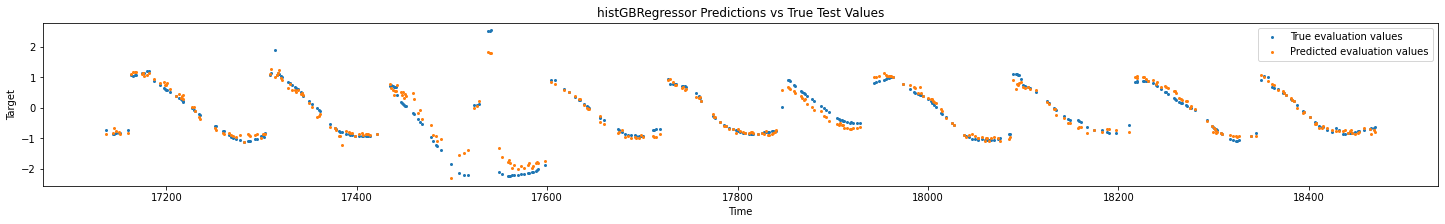

------------------------------------------------------------------------------------
UPE_U
R^2 score on test set (seasonal_residual):  0.8641570154661207
MSE on test set (seasonal_residual):  0.04120683588876689


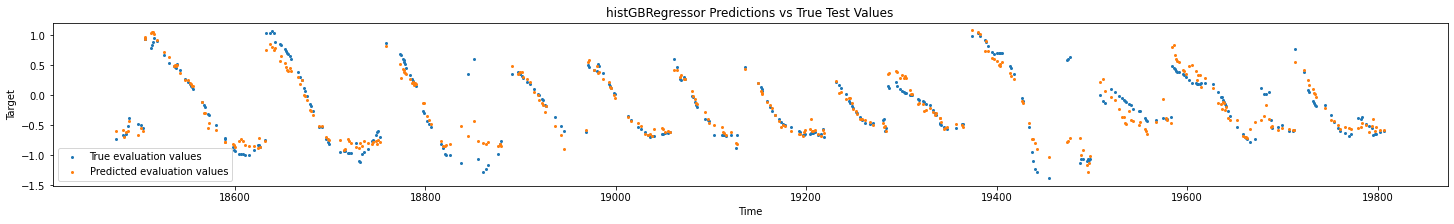

In [33]:
# This bit to find best HistGradientBoostingRegressor model for when Ablation == True and for both target variables
model = HistGradientBoostingRegressor()

# Grid used in Hyperparameter Tuning

param_grid = {
    'max_depth': [15],#[3, 5, 7],
    'min_samples_leaf': [10],#[1, 3, 5],
    'learning_rate': [0.05],#[0.1, 0.01, 0.001],
    'max_iter': [500],#[100, 500, 1000],
    'l2_regularization': [0],#[0, 0.1, 0.5]
}

# Define the grid search object
grid_search = GridSearchCV(model, param_grid = param_grid, cv=cv, n_jobs=-1, verbose=5)

# Fit the grid search object to the training data
grid_search.fit(X_train, y_train)


# Print the best hyperparameters and the corresponding R^2 score on the test set
print(f"Best hyperparameters_{y}: ", grid_search.best_params_)
print('------------------------------------------------------------------------------------')
# Save the best model parameters as 'model' variable
exec(f"hist_model_{y} = grid_search.best_estimator_")

# Evaluate the best model on the test set
y_pred = eval(f"hist_model_{y}").predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred, squared=True)
print("Average R^2 test score from cv :", grid_search.cv_results_["mean_test_score"][0])
print("Standard deviation of R^2 test scores from cv:", grid_search.cv_results_["std_test_score"][0])
mean_test_score = grid_search.cv_results_["mean_test_score"][0]
std_test_score = grid_search.cv_results_["std_test_score"][0]

best_estimator = grid_search.best_estimator_
param_name = 'learning_rate'
param_range = np.arange(0.01, 0.05, 0.1)
#plot_validation_curve(best_estimator, "Validation Curve (XGBRegressor)", X_train, y_train, param_name, param_range, cv=cv)
#plt.show()

plot_learning_curve(best_estimator, "Learning Curve (histGB)", X_train, y_train, cv=cv)
plt.show()

print('------------------------------------------------------------------------------------')
print(f"R^2 score on validation set ({y}): ", r2)
print(f"MSE on validation set ({y}): ", mse)

y_pred_station = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_station = scaler.inverse_transform(y_test.values.reshape(-1, 1))

plt.figure(figsize=(25, 3))
plt.scatter(X_test.index, y_test_station, label="True evaluation values", alpha=1, s=4)
plt.scatter(X_test.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)

plt.xlabel("Time")
plt.ylabel("Target")
plt.title("histGB Predictions vs True Test Values")
plt.legend()
plt.show()


for value, station_name in enumerate(station_names):
    print('------------------------------------------------------------------------------------')
    print(station_name)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = eval(f"hist_model_{y}").predict(X_test_station)
    y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    y_test_station = scaler.inverse_transform(y_test_station.values.reshape(-1, 1))
    
    y_pred_train_station = eval(f"hist_model_{y}").predict(X_test_station)
    r2_station = r2_score(y_test_station, y_pred_station)
    mse_station = mean_squared_error(y_test_station, y_pred_station, squared=True)
    
    print(f"R^2 score on test set ({y}): ", r2_station)
    print(f"MSE on test set ({y}): ", mse_station)
    
    plt.figure(figsize=(25, 3))
    plt.scatter(X_test_station.index, y_test_station, label="True evaluation values", alpha=1, s=4)
    plt.scatter(X_test_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
   
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.title("histGBRegressor Predictions vs True Test Values")
    plt.legend()
    plt.show()

------

R^2 score on validation set (filtred):  0.716789572383262
MSE on validation set (filtred):  0.0017542387357122797
Count of filtred values:  2166
------------------------------------------------------------------------------


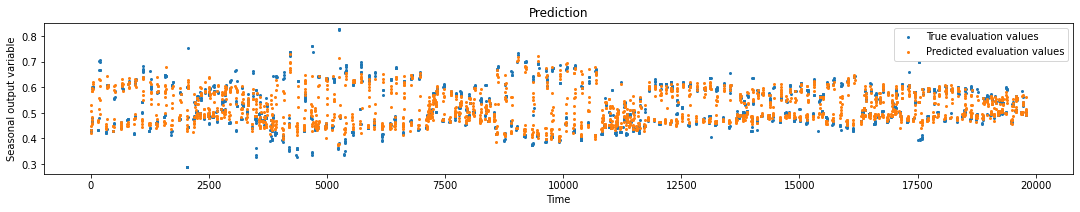

KAN_L
R^2 score on validation set (filtred):  0.543124606065827
RMSE on validation set (filtred):  0.0041500004953126035
Count of filtred values:  171


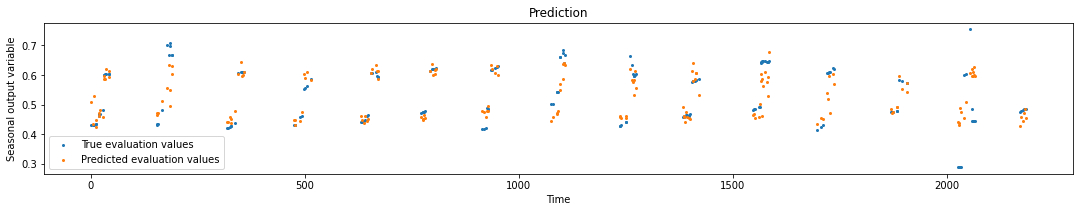

KPC_L
R^2 score on validation set (filtred):  0.6665806856097438
RMSE on validation set (filtred):  0.0007617450866048446
Count of filtred values:  151


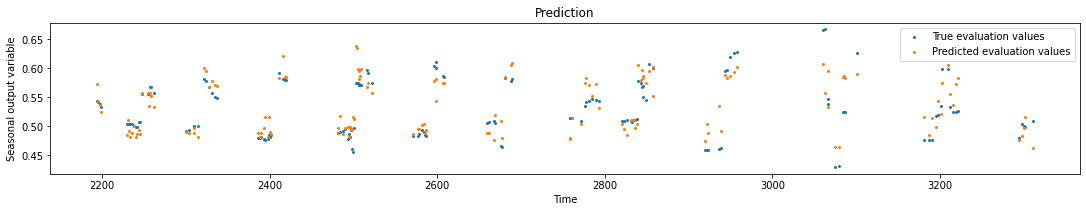

MIT
R^2 score on validation set (filtred):  0.5499704602394067
RMSE on validation set (filtred):  0.004369209518344535
Count of filtred values:  167


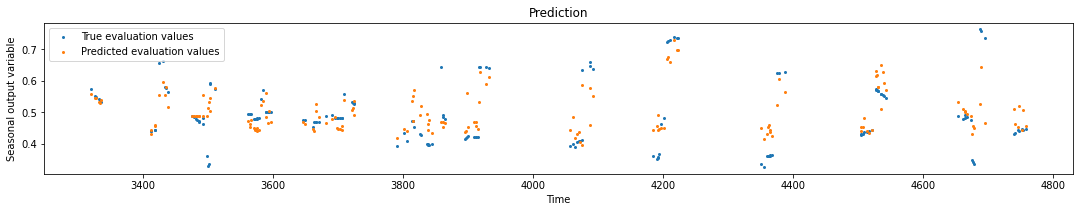

NUK_L
R^2 score on validation set (filtred):  0.6964183531170279
RMSE on validation set (filtred):  0.0037112133963946928
Count of filtred values:  203


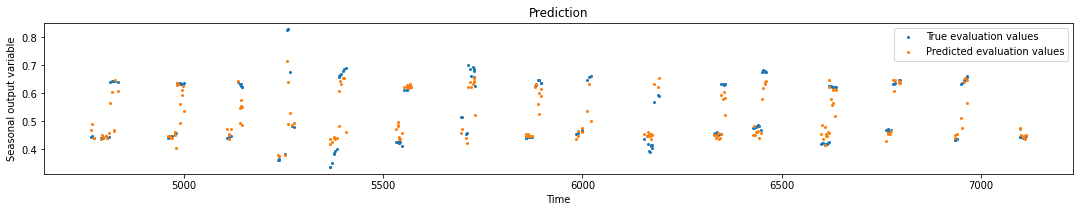

NUK_U
R^2 score on validation set (filtred):  0.5837446764380202
RMSE on validation set (filtred):  0.0007731163171023712
Count of filtred values:  193


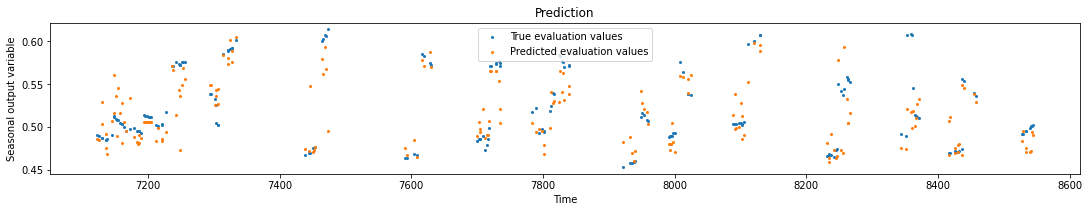

QAS_L
R^2 score on validation set (filtred):  0.8124045309698376
RMSE on validation set (filtred):  0.002704005474715164
Count of filtred values:  198


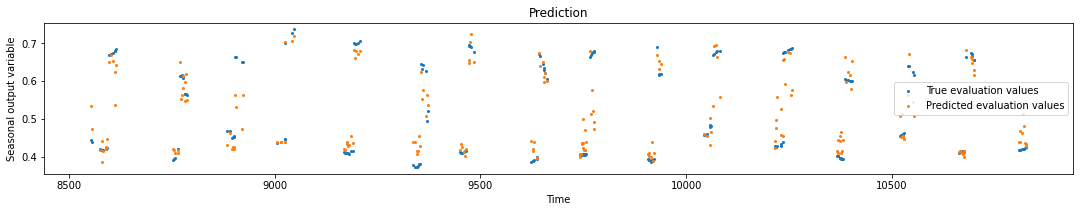

QAS_U
R^2 score on validation set (filtred):  0.5641018724633864
RMSE on validation set (filtred):  0.0007075259197357071
Count of filtred values:  148


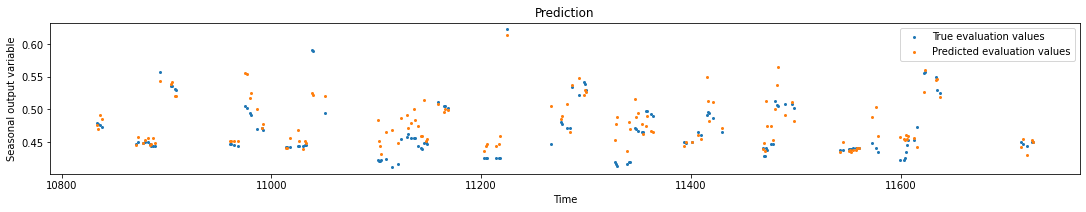

SCO_L
R^2 score on validation set (filtred):  0.8305448092736589
RMSE on validation set (filtred):  0.0008264790849668039
Count of filtred values:  197


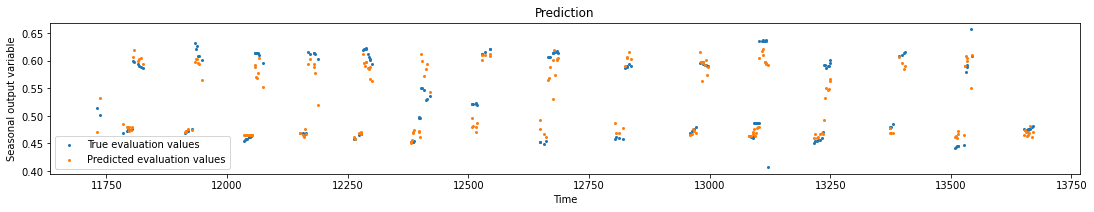

SCO_U
R^2 score on validation set (filtred):  0.8270795256782334
RMSE on validation set (filtred):  0.0004525724650332975
Count of filtred values:  193


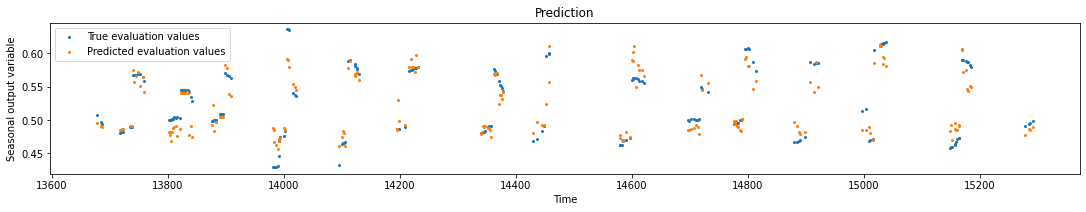

TAS_L
R^2 score on validation set (filtred):  0.8056902532296367
RMSE on validation set (filtred):  0.0011015102341397195
Count of filtred values:  92


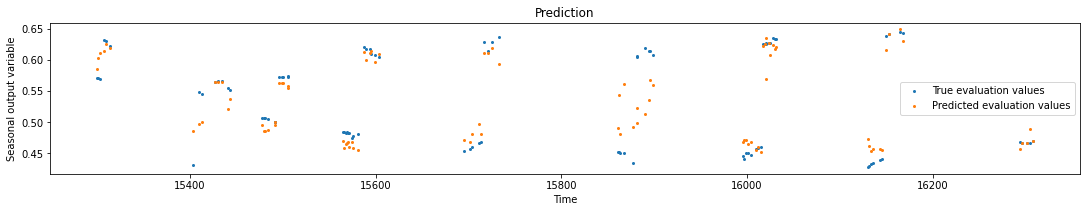

THU_L
R^2 score on validation set (filtred):  0.7818156936613254
RMSE on validation set (filtred):  0.00037341917117311263
Count of filtred values:  132


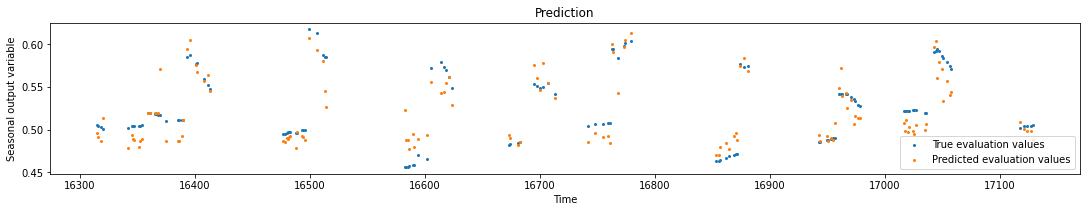

UPE_L
R^2 score on validation set (filtred):  0.6963881540288656
RMSE on validation set (filtred):  0.0014220653870484353
Count of filtred values:  152


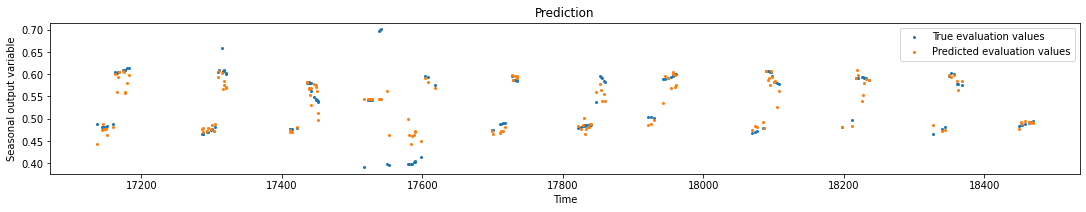

UPE_U
R^2 score on validation set (filtred):  0.6890601989745824
RMSE on validation set (filtred):  0.0005071464732139174
Count of filtred values:  169


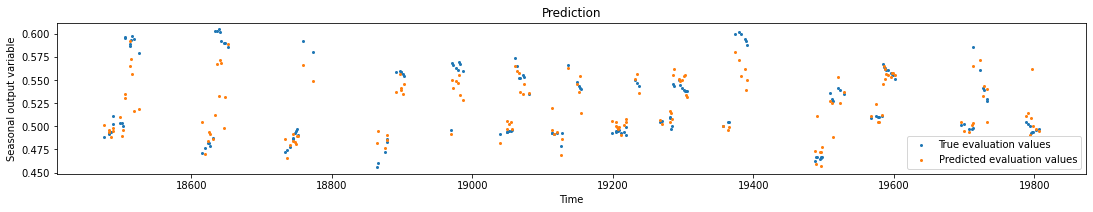

In [63]:
#filter = pd.concat([pd.Series(indices_first_melt_day), pd.Series(indices_last_melt_day)])
filter = expanded_indices_first + expanded_indices_last

# Evaluate the best model on the test set
y_pred =  xgb_model_seasonal_residual.predict(X_test.iloc[X_test.index.isin(filter)]) #eval(f"xgb_model_{y}").predict(X_test.iloc[filter])
y_test_filter = y_test.iloc[y_test.index.isin(filter)]

r2 = r2_score(y_test_filter, y_pred)
mse = mean_squared_error(y_test_filter, y_pred, squared=True)

print(f"R^2 score on validation set (filtred): ", r2)
print(f"MSE on validation set (filtred): ", mse)
print(f"Count of filtred values: ", len(y_test_filter))
print("------------------------------------------------------------------------------")

plt.figure(figsize=(15,10))
plt.subplot(4,1,4)
plt.title("Prediction")
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
plt.scatter(y_test_filter.index, y_test_filter.iloc[y_test_filter.index.isin(filter)], label="True evaluation values", alpha=1, s=4)
plt.scatter(y_test_filter.index, y_pred, label="Predicted evaluation values", alpha=1, s=4)
plt.xlabel('Time')
plt.ylabel('Seasonal output variable')
plt.legend()
plt.show()
    
for value, station_name in enumerate(station_names):
    print(station_name)

    plt.figure(figsize=(15,10))
    plt.subplot(4,1,4)
    plt.title("Prediction")
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    # Subset X_train and X_test with the values of station_names
    X_train_station = X_train.loc[X_train['stid'] == value]
    X_test_station = X_test.loc[X_test['stid'] == value]

    # Subset y_train and y_test with the indices of X_train_station and X_test_station
    y_train_station = y_train.loc[X_train_station.index]
    y_test_station = y_test.loc[X_test_station.index]

    y_pred_station = xgb_model_seasonal_residual.predict(X_test_station.iloc[X_test_station.index.isin(filter)])#eval(f"xgb_model_{y}").predict(X_test_station.iloc[filter])
    #y_pred_station = scaler.inverse_transform(y_pred_station.reshape(-1, 1))
    
    y_test_filter_station = y_test_station.iloc[y_test_station.index.isin(filter)]
    #y_test_filter_station = scaler.inverse_transform(y_test_filter_station.values.reshape(-1, 1))#.values.reshape(-1, 1))
    
    r2_station = r2_score(y_test_filter_station, y_pred_station)
    mse_station = mean_squared_error(y_test_filter_station, y_pred_station, squared=True)
    
    print(f"R^2 score on validation set (filtred): ", r2_station)
    print(f"RMSE on validation set (filtred): ", mse_station)
    print(f"Count of filtred values: ", len(y_test_filter_station))

    # Plot the seasonal output variable, trained values, tested values, and predicted values
  #  plt.scatter(y_train_station.index, y_train_station, label='Trained values', color='blue', linewidth=1)
    plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label="True evaluation values", alpha=1, s=4)
    plt.scatter(y_test_filter_station.index, y_pred_station, label="Predicted evaluation values", alpha=1, s=4)
    
 #   plt.scatter(y_test_filter_station.index, y_test_station.iloc[y_test_station.index.isin(filter)], label='True values',  linewidth=0.5)
 #   plt.scatter(y_test_filter_station.index, y_pred_station, label= 'Predicted values',linewidth=0.4)


    # Plot the pre_max values
    #plt.scatter(indices_pre_max, df.loc[indices_pre_max, 'seasonal_residual'], c='r', marker='.', label='pre_max', s=4 )

    # Plot the post_max values
    #plt.scatter(indices_post_max, df.loc[indices_post_max, 'seasonal_residual'], c='g', marker='.', label='post_max',s=4)

    # Plot the pre_min values
    #plt.scatter(indices_pre_min, df.loc[indices_pre_min, 'seasonal_residual'], c='r', marker='.', label='pre_min',s=4)

    # Plot the post_min values
    #plt.scatter(indices_post_min, df.loc[indices_post_min, 'seasonal_residual'], c='g', marker='.', label='post_min',s=4)

    plt.xlabel('Time')
    plt.ylabel('Seasonal output variable')
    plt.legend()
    plt.show()

## Filter by Melting Season and get feature importances 

In [64]:
import shap

explainer = eval(f"shap.Explainer(xgb_model_{y})")

In [65]:
X_set = X_test
y_set = y_test 

positive_color = "#ca0020"
negative_color = "#92c5de"

In [66]:
# Filter out here whatever period to focus on

#filter = indices_middle.to_list()
#filter = indices_last_melt_day.to_list()
filter = expanded_indices_last
#filter = indices_first_melt_day.to_list()
#filter = expanded_indices_first

#shap_values = explainer(X_set.loc[filter])
shap_values = explainer(X_set.iloc[X_set.index.isin(filter)])

mean_abs_shap_values = shap_values.abs.mean(0)

#X = X_set.loc[filter]
X = X_set.iloc[X_set.index.isin(filter)]
y_set = y_set[y_set.index.isin(filter)]
max_abs_shap_value = np.max(np.abs(shap_values.values))
shap_values = shap_values.values / max_abs_shap_value

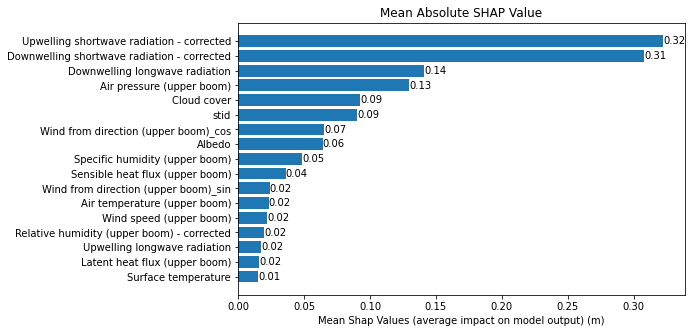

In [67]:
feature_names = X_set.columns
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

# Get the sorted order of the features based on the mean absolute SHAP values
sorted_feature_indices = np.argsort(mean_abs_shap_values)
sorted_feature_names = feature_names[sorted_feature_indices]
# Create a custom vertical summary plot with feature labels on the left
plt.figure(figsize=(8, 5))
bar_plot = plt.barh(sorted_feature_names, mean_abs_shap_values[sorted_feature_indices])
plt.xlabel("Mean Shap Values (average impact on model output) (m)")
plt.title("Mean Absolute SHAP Value")
# Add labels to the bars
for rect in bar_plot:
    width = rect.get_width()
    plt.text(width, rect.get_y() + rect.get_height() / 2.0, "{:.2f}".format(width), ha="left", va="center")
plt.show()

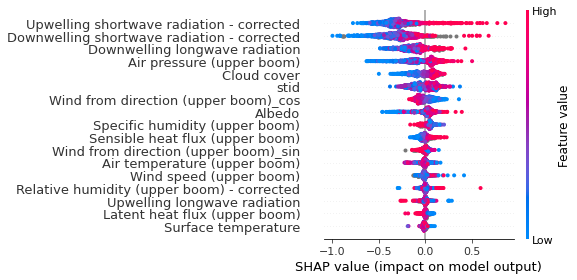

In [68]:
shap.summary_plot(shap_values, X, plot_type="dot", plot_size = (8,4))

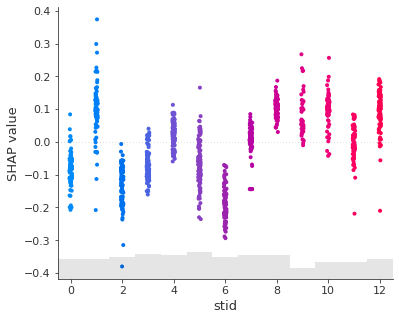

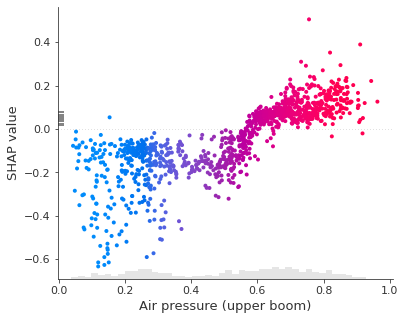

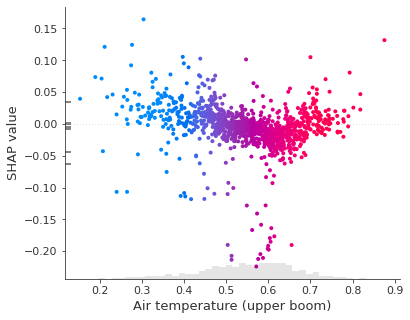

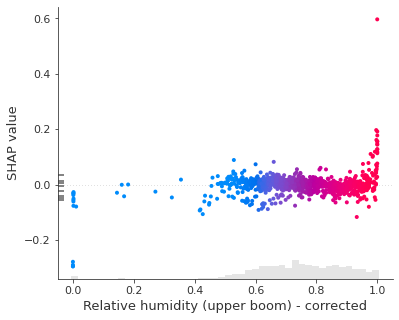

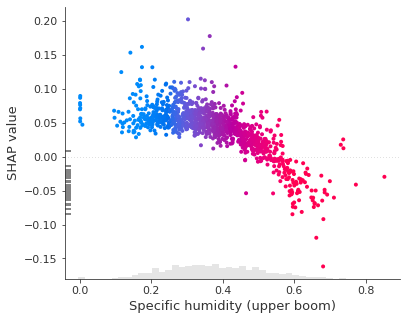

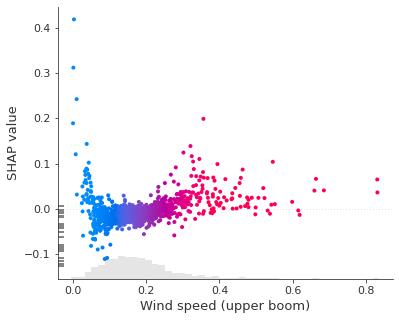

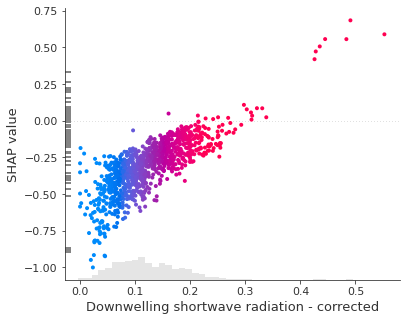

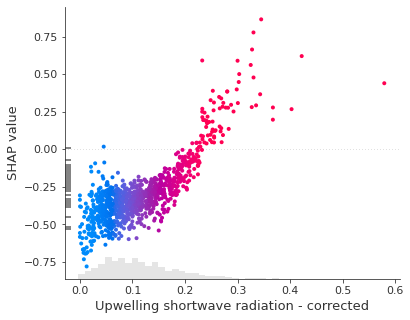

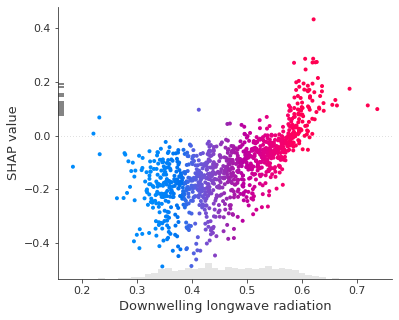

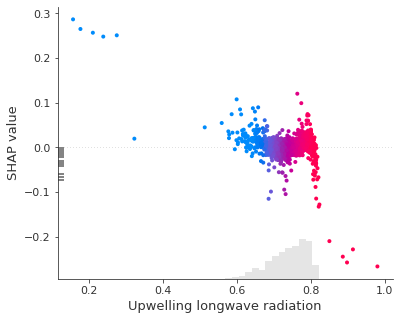

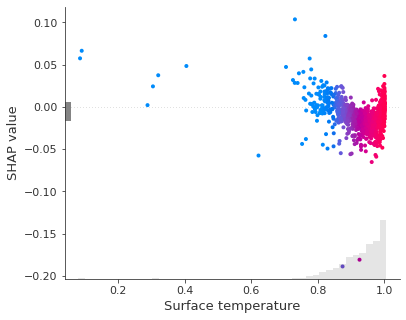

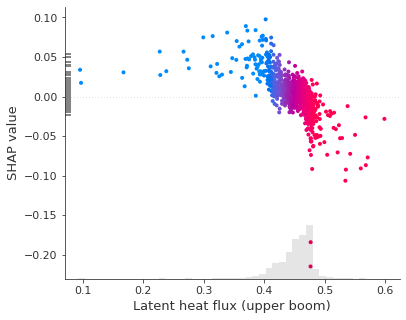

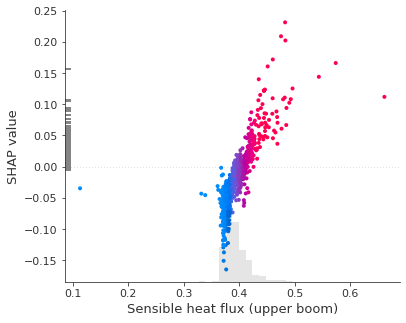

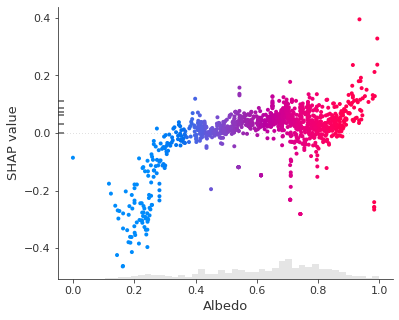

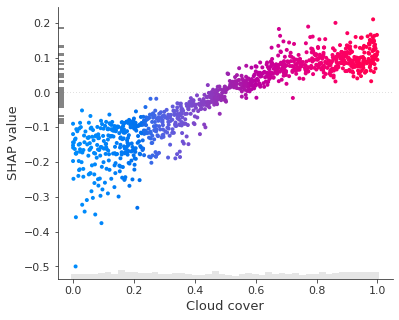

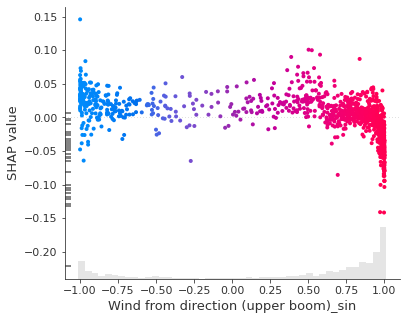

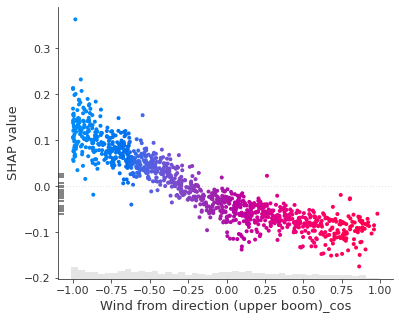

In [69]:
for i in range(17):
    # Create a new Explanation object with the desired feature's SHAP values
    single_feature_shap_values = shap.Explanation(
        shap_values[:, i].reshape(-1, 1),
        explainer.expected_value,
        #X_set.loc[filter].values[:, i].reshape(-1, 1),
        X.values[:, i].reshape(-1, 1),
        feature_names=[X_set.columns[i]]
    )
    shap.plots.scatter(single_feature_shap_values, color=single_feature_shap_values)
    

-------